# SPARK SQL (CLOUDS Fall 2018)

In this notebook, we will learn how to use the DataFrame API and SparkSQL to perform simple data analytics tasks.

# Goals
The main goals of this notebook are the following:
1. Understand the advantages and disadvantages of using DataFrame over RDD
2. Analyze the airline data with the DataFrame API and SparkSQL

# Steps

- First, in section 1, we will go through a short introduction about the DataFrame API with a small example to see how can we use it and how it compares to the low-level RDD abstraction.
- In section 2, we delve into the details of the use case of this notebook including: providing the context, introducing the data
- In section 3, we perform data exploration and analysis

# 1. RDD and DataFrame APIs

In our previous notebooks, we have worked with RDDs (Resilient Distributed Dataset), the basic abstraction in Spark. The main reason is due to the task at hand: we have been invovled in the design of distributed algorithms.

In this laboratory session, we study (or revisit) the DataFrame API - an immutable distributed collection of data.
DataFrames allow developers to impose a **structure** on a distributed collection of data, allowing higher-level abstraction; in addition, DataFrames provide a domain specific language (DSL) API to manipulate distributed, structured data. Ultimately, the goal is to make Spark accessible to a wider audience, beyond researchers and specialized data engineers.

Let's take a small example to see the difference between RDDs and DataFrames. The two cells below contain short code snippets that perform the same task: count the frequency of words in a document, then sort the result in descending order. The first snippet is the same you have been working on in the very [first notebook](https://github.com/EURECOM-CLOUDS-COURSE/Introduction/blob/master/introduction-lab.ipynb) of the CLOUDS course.
The second code snippet uses the DataFrame API.

<div class="alert alert-block alert-info">

<strong>Question 1.</strong> 

Run both approaches (RDD and DataFrame) detailed below, compare their runtime, and discuss. Is the DataFrame API approach faster? Can you explain why?

</div>

In [1]:
import time
time_start = time.time()
words = (
            # read the text file
            sc.textFile("/datasets/gutenberg/gutenberg_small.txt").repartition(16)
            
            # construct words from lines
            .flatMap(lambda line: line.split())
            
            # map each word to (word, 1)
            .map(lambda x: (x, 1))
    
            # reduce by key: accumulate sum the freq of the same word
            .reduceByKey(lambda freq1, freq2: freq1 + freq2)
            
            # swap (word, freq) to (freq, word)
            .map(lambda x: (x[1], x[0]))
    
            # sort result by key DESC
            .sortByKey(False)
         )
print("Runtime: %.2f sec" % (time.time() - time_start))
print(words.take(5))

Runtime: 161.25 sec
[(29556020, 'the'), (18043957, 'of'), (14914748, 'and'), (12892052, 'to'), (9779124, 'a')]


In [2]:
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import explode, split, desc
sqlContext = SQLContext(sc)
time_start = time.time()

# read the text file
df = sqlContext.read.text("/datasets/gutenberg/gutenberg_small.txt")

# show 3 samples
# df.show(3)

result = (
    # split into words
    df.select(explode(split(df.value, "\s+|\t+")).alias('word'))
    
    # group by each word
    .groupBy(['word'])
    
    # count the freq
    .count()
    
    # sort the result
    .orderBy(desc("count"))
)

result.show(5)
print("Runtime: %.2f sec" % (time.time() - time_start))

+----+--------+
|word|   count|
+----+--------+
| the|29556020|
|  of|18043957|
|    |16611988|
| and|14914748|
|  to|12892052|
+----+--------+
only showing top 5 rows

Runtime: 119.27 sec


The RDD approach took 184.52 seconds whereas the DataFrame API approach ran during 130.29 seconds, it is then faster, 1.4 times faster.  An RDD is a distributed collection of data elements that are spread across many machines in the cluster. A DataFrame is a distributed collection of data organized into named columns. It is conceptually equal to a table in a relational database. The DataFrame API approach is then faster for aggregation tasks like this one, counting the frequency of words in a large set of data.

# 2. Analysis of flight data using the DataFrame API and SparkSQL

## Use case

In this notebook, we play the role of a data scientist working in the travel industry, specifically on air transportation of passengers. We want to explore the data collected by the Department of Transportation (DoT) to understand passengers' behavior, as well as the properties of all flights, across several airline companies.

The dataset provided by the DoT has 29 features, that can be either categorical or numerical. For example, the ```src_airport``` (source airport) is categorical: there exist no comparison operator between airport names. We can not say "SGN is bigger than NCE". The ```departure_time``` feature is numerical, for which a comparison operator exists. For instance, "flight departing before 6PM" can be express by "departure_time < 1800".

In this use case, most features are numerical, except carrier, flight_number, cancelled, cancelation_code and diverted. 
The data contains a header, that is useless when analyzing the data: it serves the purpose of an "embedded schema", to help data scientist figure out what information is available. Note that there are some features with missing values in some lines of the dataset. The missing values are marked by "NA". These values can cause problems when processing the data and can lead to unexpected results. Therefore, we need to remove the header and replace all "NA" values by empty values, such as they can be interpreted as null values.

## DataFrame
As we have seen already, there are multiple ways to manipulate data:

- Using the RDD abstraction

- Using the DataFrame abstraction. 

A DataFrame is a distributed collection of data organized into named columns. It is based on the data frame concept in R language or in Pandas for Python. In some sense, it is similar to a table in a relational database: each item is a list of values (the columns). Also, the value in each row of each column can be accessed by the column's name.

To use DataFrames, the data should be clean (no invalid values). That means we cannot create DataFrame directly from the "RAW" data. Instead, we will first create an RDD from RAW data, produce a new, clean RDD, then transform it to a DataFrame and work on it. The RDD `cleaned_data` is an `RDD[String]`. We need to transform it to `RDD[(TypeOfColumn1, TypeOfColumn2, ..., TypeOfColumn29)]` then call a function to create a DataFrame from the new RDD. Please note that, package `com.databricks.spark.csv` can really help us to load the data efficiently without concerns about parsing, conversions, etc... However, the CSV package can have some problems when loading not well-formatted data or the data that has many kinds of missing values. The guidelines defined this notebook are a general way to help you work with any data.


DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing RDDs.

During the labs in this course, we will mainly work with CSV data files. So, in the next sections, we only focus on constructing dataframes from structured data files directly and from existing RDD.

### Constructing a DataFrame directly from structured data file

To construct DataFrame from a structured file directly, the file type must be supported. Currently, Spark supports csv, json, avro and many more. Among these types, the csv type is one of the most popular in data analytics. A DataFrame is constructed from csv files by using the package spark-csv from Databricks.


In [3]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

df = sqlContext.read.load('/datasets/airline/1994.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

Using the function load parametrized with `com.databricks.spark.csv`, we ask the SqlContext to use the parser from the DataBricks package. Additionally, we can specify whether the file has a header, or ask the parser to guess the data type of columns automatically. The parsed data types is viewed using the function printSchema.

In [4]:
# print(df.dtypes)
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |

As you can see, the automatically inferred data types are **not** as expected. For example, we expect that `CRSDepTime` to be of interger type. The type and the name of each column can be modified using function ```withColumn``` and ```withColumnRename``` respectively. Additionally, we can also compute and print basic descriptive statistics of numerical columns via the function ```describe``` (similar to Pandas).

In [5]:
df = (df
          # change type of column CRSDepTime by casting its values to interger type
          .withColumn('CRSDepTime', df.CRSDepTime.cast('int'))

          # rename the column
          .withColumnRenamed('CRSDepTime', 'scheduled_departure_time')
    )

# print schema of the current data
df.printSchema()

# run jobs to calculate basic statistic information and show it
df.describe().show()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nulla

### Constructing a DataFrame from an existing RDD

Another way to construct a DataFrame is using data from an existing RDD. The main advantage of this approach is that it does not need a third party library. However, with this method, we have to remove the header ourself and provide a clear schema.



In [6]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import explode, split, desc, col, udf, round
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import seaborn as sns

sqlContext = SQLContext(sc)

data = sc.textFile('/datasets/airline/1994.csv')

# extract the header
header = data.first()

# replace invalid data with NULL and remove header
cleaned_data = (
        data
    
        # filter out the header
        .filter(lambda line: line != header)
    
         # replace the 'missing data' by empty value
        .map(lambda line: ','.join(list(map(lambda x: x if x != 'NA' else '',line.split(',')))))
    )

airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(),  True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])

In [7]:
# convert each line into a tuple of features (columns) with the corresponding data type
cleaned_data_to_columns = (
    cleaned_data.map(lambda l: l.split(","))
    .map(lambda cols: 
         (
            int(cols[0])  if cols[ 0] else None,
            int(cols[1])  if cols[ 1] else None,
            int(cols[2])  if cols[ 2] else None,
            int(cols[3])  if cols[ 3] else None,
            int(cols[4])  if cols[ 4] else None,
            int(cols[5])  if cols[ 5] else None,
            int(cols[6])  if cols[ 6] else None,
            int(cols[7])  if cols[ 7] else None,
            cols[8]       if cols[ 8] else None,
            cols[9]       if cols[ 9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))             
)
    
# create dataframe
df = sqlContext.createDataFrame(cleaned_data_to_columns, airline_data_schema)\
    .select(['year', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time','scheduled_arrival_time',
            'arrival_delay', 'distance', 
            'src_airport', 'dest_airport', 'carrier'])\
    .cache()

### Examples

Using the contructed DataFrame, we can answer some simple questions:

<ul>
<li>How many night flights do we have in our data?</li>
<li>How many night flights per unique carrier?</li>
</ul>

<strong>NOTE:</strong> We define "night" to start at 6pm.

In [8]:
df[df.scheduled_departure_time > 1800].count()

1078203

In [9]:
df[df.scheduled_departure_time > 1800].groupBy(df.carrier).count().orderBy('count', ascending=0).collect()

[Row(carrier='DL', count=208224),
 Row(carrier='US', count=170397),
 Row(carrier='AA', count=142832),
 Row(carrier='WN', count=124024),
 Row(carrier='UA', count=113640),
 Row(carrier='NW', count=100453),
 Row(carrier='CO', count=94501),
 Row(carrier='TW', count=54771),
 Row(carrier='HP', count=44351),
 Row(carrier='AS', count=25010)]

# 3. Data exploration
Next, we will go over a series of simple queries on our data, to perform exploration and compute statistics using the DataFrame API and SparkSQL. These queries directly map to the questions you need to answer. 

**NOTE:** finding the right question to ask is difficult! Don't be afraid to complement the questions below, with your own questions that, in your opinion, are valuable ways to inspect data. This can give you extra points!

- Basic queries:
  - How many unique origin airports?
  - How many unique destination airports?
  - How many carriers?
  - How many flights that have a scheduled departure time later than 18h00?


- Statistics on flight volume: this kind of statistics are helpful to reason about delays. Indeed, it is plausible to assume that "*the more flights in an airport, the higher the probability of delay*".
  - How many flights in each month of the year?
  - Is there any relationship between the number of flights and the days of week?
  - How many flights in different days of months and in different hours of days?
  - Which are the top 20 busiest airports (this depends on inbound and outbound traffic)?
  - Which are the top 20 busiest carriers?


- Statistics on the fraction of delayed flights
  - What is the percentage of delayed flights (over total flights) for different hours of the day?
  - Which hours of the day are characterized by the longest flight delay?
  - What are the fluctuation of the percentage of delayed flights over different time granularities?
  - What is the percentage of delayed flights which depart from one of the top 20 busiest airports?
  - What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?

## Question 2: Basic queries

### Question 2.1
<div class="alert alert-info">

How many origin airports? How many destination airports? Discuss the results, indicating any discrepancies or strange facts about the data.

</div>

In [10]:
nb_src = df.select("src_airport").distinct().count()
nb_dest = df.select("dest_airport").distinct().count()

print("The number of origin airports is", nb_src)
print("The number of destination airports is", nb_dest)


The number of origin airports is 224
The number of destination airports is 225


**Answer 2.1**

It is very odd that there is one more destination airport (225 against 224). It would mean that planes land on an airport and never leave from it. A more logical explanation would be that there was a mistake in an airport's name at one point and it was thus counted twice.

### Question 2.2

<div class="alert alert-info">
How many unique carriers are present in the data?
</div>

In [11]:
nb_carrier = df.select("carrier").distinct().count()

print("The number of carriers is", nb_carrier)

The number of carriers is 10


**Answer 2.2**

There are only ten different carriers present in the data.

### Question 2.3

<div class="alert alert-info">
<ul>
<li>How many night flights (that is, flights departing later than 6pm or earlier than 6am)?</li>
<li>What is the percentage of night flights over the total volume of flights</li>
</ul>

<br>
<br>
<strong>NOTE:</strong> Here we're using a more refined definition of what is a night flight, than in our earlier examples.

</div>

In [12]:
nb_night_flights = df[(df.scheduled_departure_time > 1800) | (df.scheduled_departure_time < 600)].count()
nb_flights = df.count()
per_night_flights = 100 * nb_night_flights / nb_flights

nb_night_flights1 = df[(df.scheduled_departure_time > 1800)].count() #according to the previous definition
nb_flights1 = df.count()
per_night_flights1 = 100 * nb_night_flights1 / nb_flights

print("The number of night flights is", nb_night_flights)
print("The percentage of night flights over the total volume of flights is", per_night_flights,"%")

print("The number of night flights is", nb_night_flights1)
print("The percentage of night flights over the total volume of flights is", per_night_flights1,"%")

The number of night flights is 1121918
The percentage of night flights over the total volume of flights is 21.658447952605844 %
The number of night flights is 1078203
The percentage of night flights over the total volume of flights is 20.814536853712553 %


**Answer 2.3**

There are 1121918 night flights according to the new definition, which represents 21.66 percent of the total volume of flights, understandable. Also, we can notice that the new definition (adding the flights between midnight and before 6AM) only adds less than 1 percent, which is logical as well, only a few flights depart between midnight and 6AM.

## Question 3: Flight volume statistics

### Question 3.1: 

<div class="alert alert-info">
How many flights in each month of the year? Plot the changes over months by a line chart and comment the figure.

<br>
From the result, we can learn the dynamics of flight volume over months. For example, if we only consider flights in 1994 (to start, it's always better to focus on smaller amount of data), we can discuss about which months are most likely to have flights experiencing delays.
</div>


Text(0.5,1,'Changes over months')

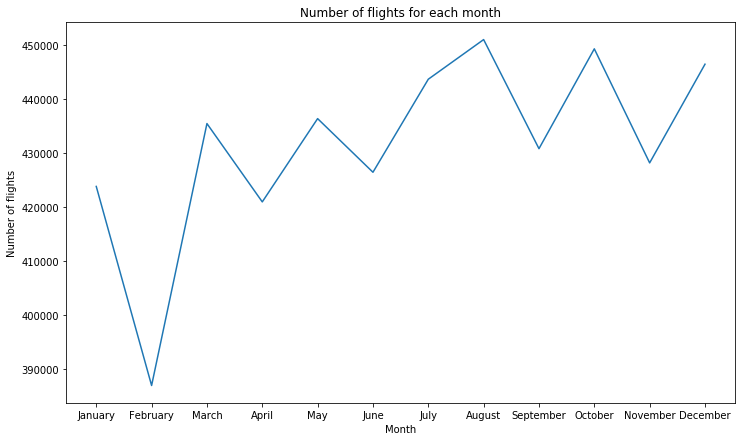

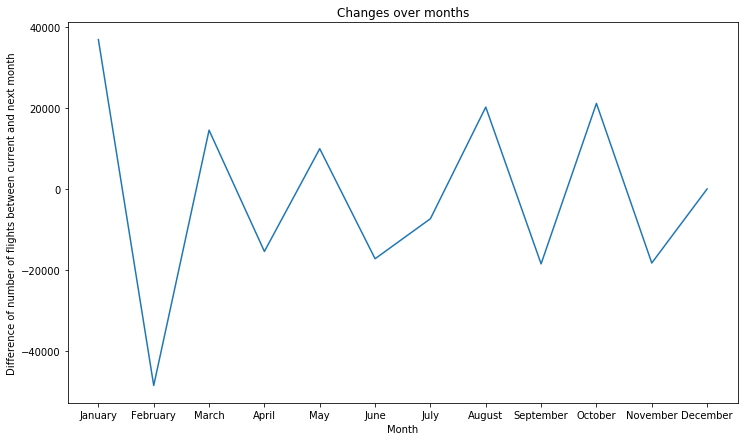

In [13]:
###Computing the number of flights for each month of the year and plotting the results, and plotting the successive changes

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


flights_month = df.groupBy("month").count().orderBy("month", ascending=1).collect()

pdf = pd.DataFrame(data=flights_month)

changes_month = []
for i in range(len(pdf[0]) - 1):
    changes_month.append(pdf[1][i] - pdf[1][i + 1])

changes_month.append(0)
plt.figure(figsize = (12,7))
plt.plot(pdf[0], pdf[1])
plt.xlabel("Month")
plt.ylabel("Number of flights")
plt.title("Number of flights for each month")
plt.xticks(range(1,13), months)

plt.figure(figsize = (12,7))
plt.plot(months, changes_month)
plt.xlabel("Month")
plt.ylabel("Difference of number of flights between current and next month")
plt.title("Changes over months")

**Answer 3.1**

I plotted the number of flights for each month, we can notice that the month where there is the most flights is August. More generally, it seems like there are more flights at the end of the year than the beginning of the year, it would be interesting to compare this data to other years.
I also plotted the changes over months, the difference between the number of flights of the current month and the number of flights of the next month. This allows us so notice that for longer months (31 days) there is more flights. This is even more obvious for Februrary, 3 days less than March.

### Question 3.2: 

<div class="alert alert-info">
Is there any relationship between the number of flights and the days of the week?  

Plot a bar chart and interpret the figure.

<br>
<br>
<strong>NOTE:</strong> You should study both global aggregates (irrespectively of the month of the year), and monthly aggregates (day statistics, for each different month of the year).

<br>
<br>
By answering this question, we could learn about the importance of the weekend/weekday feature for our predictive task.
</div>

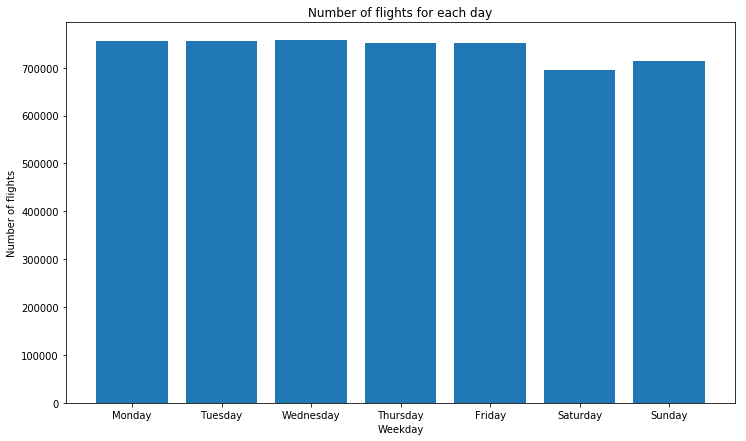

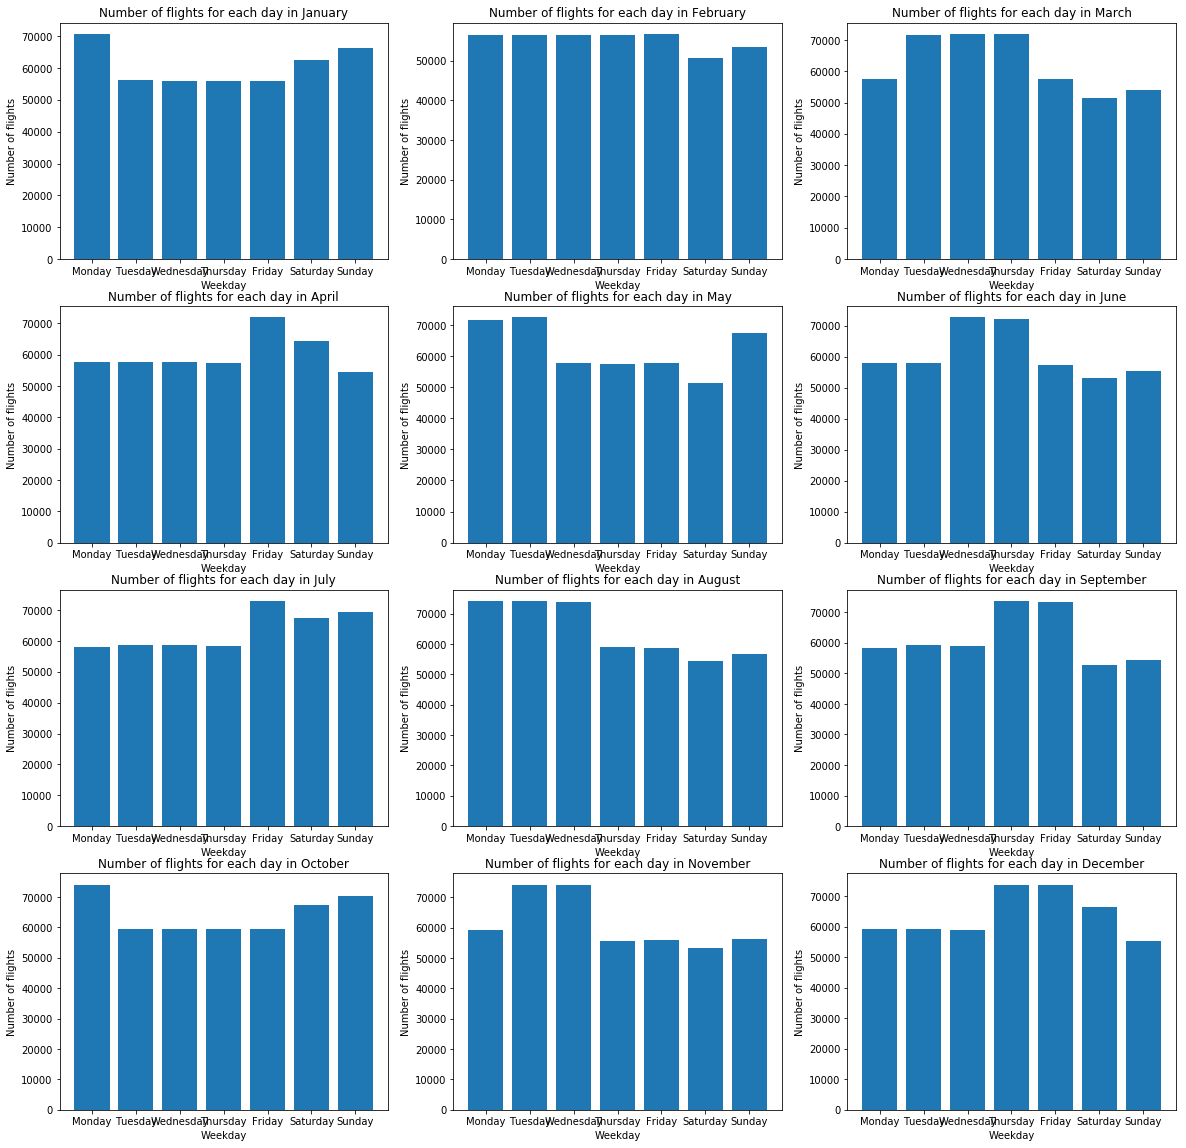

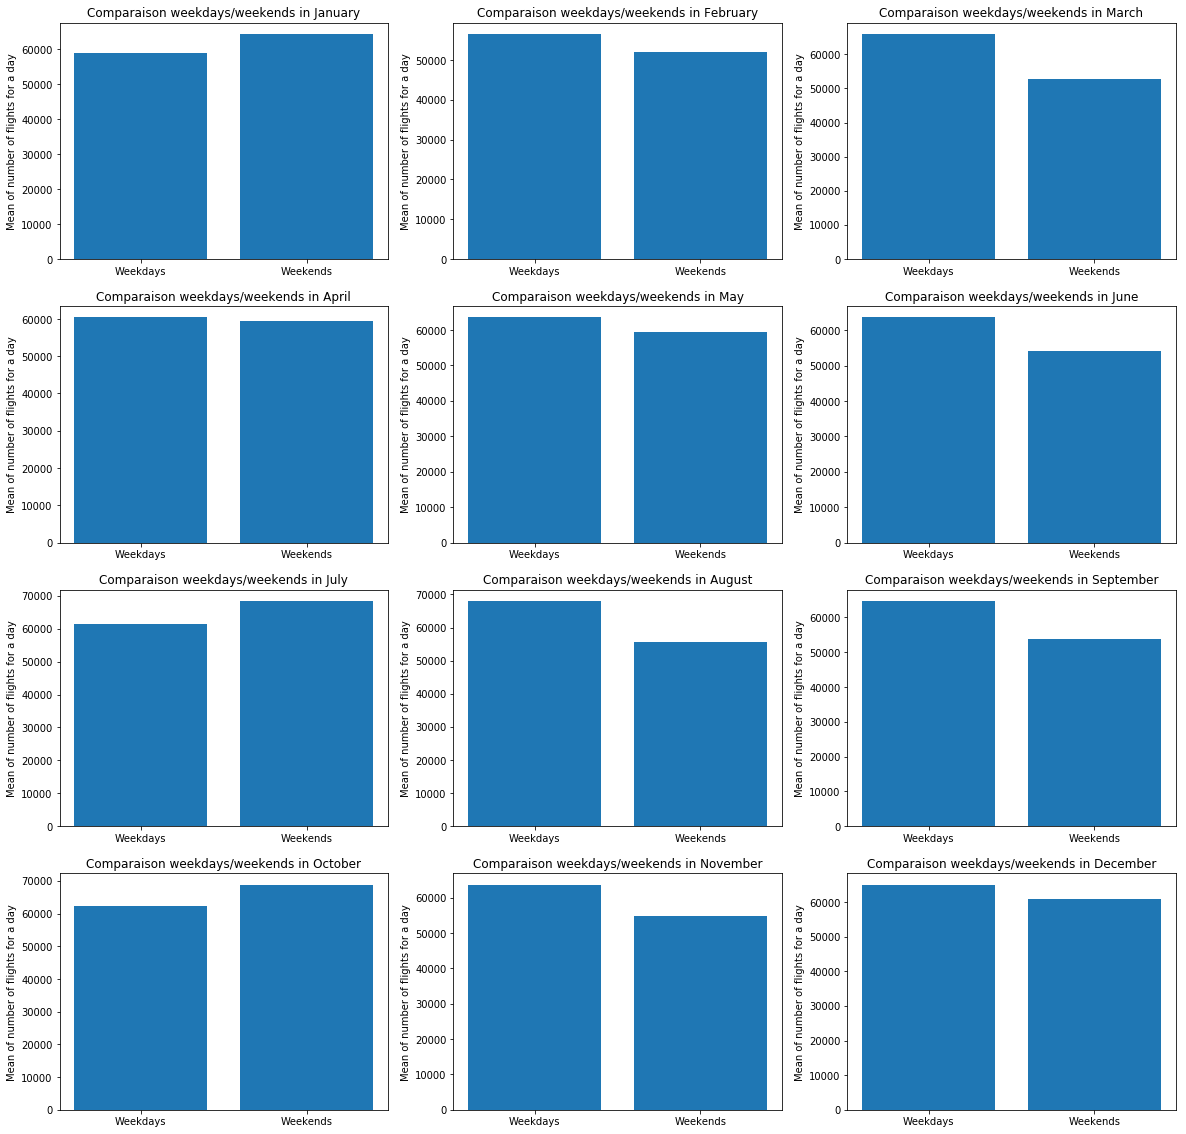

In [14]:
###Computing the number of flights for each day of the week

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

#aggregates irrespectively of the month of the year
flights_week = df.groupBy('day_of_week').count().orderBy('day_of_week', ascending=1).collect()

pdf_week = pd.DataFrame(data=flights_week)

plt.figure(figsize =(12,7))
plt.bar(pdf_week[0], pdf_week[1])
plt.xlabel("Weekday")
plt.ylabel("Number of flights")
plt.title("Number of flights for each day")
plt.xticks(range(1,8), weekdays)

#monthly aggregates

count_per_day_month = []
for i in range(12):
    count_per_day_month.append(df[df.month == i+1].groupBy('day_of_week').count().orderBy('day_of_week', ascending=1).collect())

plt.figure(figsize =(20,20))
for i in range(12):
    days_month = [count_per_day_month[i][j][1] for j in range(7)] 
    plt.subplot(4,3,i+1)
    plt.title("Number of flights for each day in " +months[i])
    plt.bar(weekdays, days_month)
    plt.xlabel("Weekday")
    plt.ylabel("Number of flights")
    
    
#comparaison between weekdays and weekends on a monthly basis

count_week_days = 12*[0]
count_week_ends = 12*[0]

plt.figure(figsize=(20,20))
for i in range(12):
    for j in range(0,5):
        count_week_days[i] += count_per_day_month[i][j][1]
    count_week_days[i] /= 5
    for j in range(5,7):    
        count_week_ends[i] += count_per_day_month[i][j][1]
    count_week_ends[i] /= 2
    plt.subplot(4,3,i+1)
    plt.title("Comparaison weekdays/weekends in " +months[i])
    plt.ylabel("Mean of number of flights for a day")
    plt.bar(["Weekdays", "Weekends"], [count_week_days[i],count_week_ends[i]])


**Answer 3.2**

On a yearly basis we can see that there are more flights during the weekdays than during the weekend. However when we aggregate on a monthly basis, it differs, on January there are lots of flights on Mondays but on July the days of the weekends seem to be more succesful. By comparing directly weekends and weekdays (by doing a mean on a day of flights between Monday to Friday and Saturday and Sunday), we notice more accurately that this trend differs according to the month.

Monthly, the number of flights for each day varies a lot. This is due mainly to the fact that the number of each day varies according to the month (sometimes it is 4 sometimes it is 5). We can notice this clearly by looking at the monthly charts. For long months (31 days) there are always 3 bars that are a bit above the others (because there are five days of three days of the week). For the same reason, for short months, two bars are above the others. Finally, for February there is 28 days (1994 was not a leap year) and the trend is very similar to the one of the yearly basis.

### Question 3.3

<div class="alert alert-info">
How many flights in different days of months and in different hours of days?  
<br>
<br>

<strong>NOTE:</strong> Similarly to the previous note, you need to compute both global statistcs and monthly statistics.

<br>
<br>
Plot  bar charts, and interpret your figures.
</div>

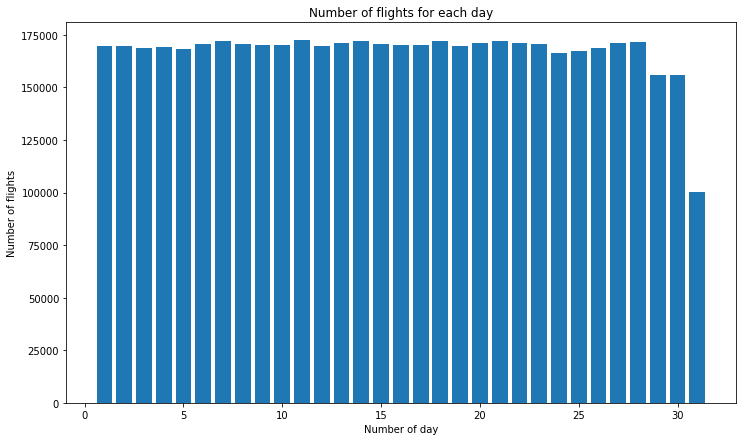

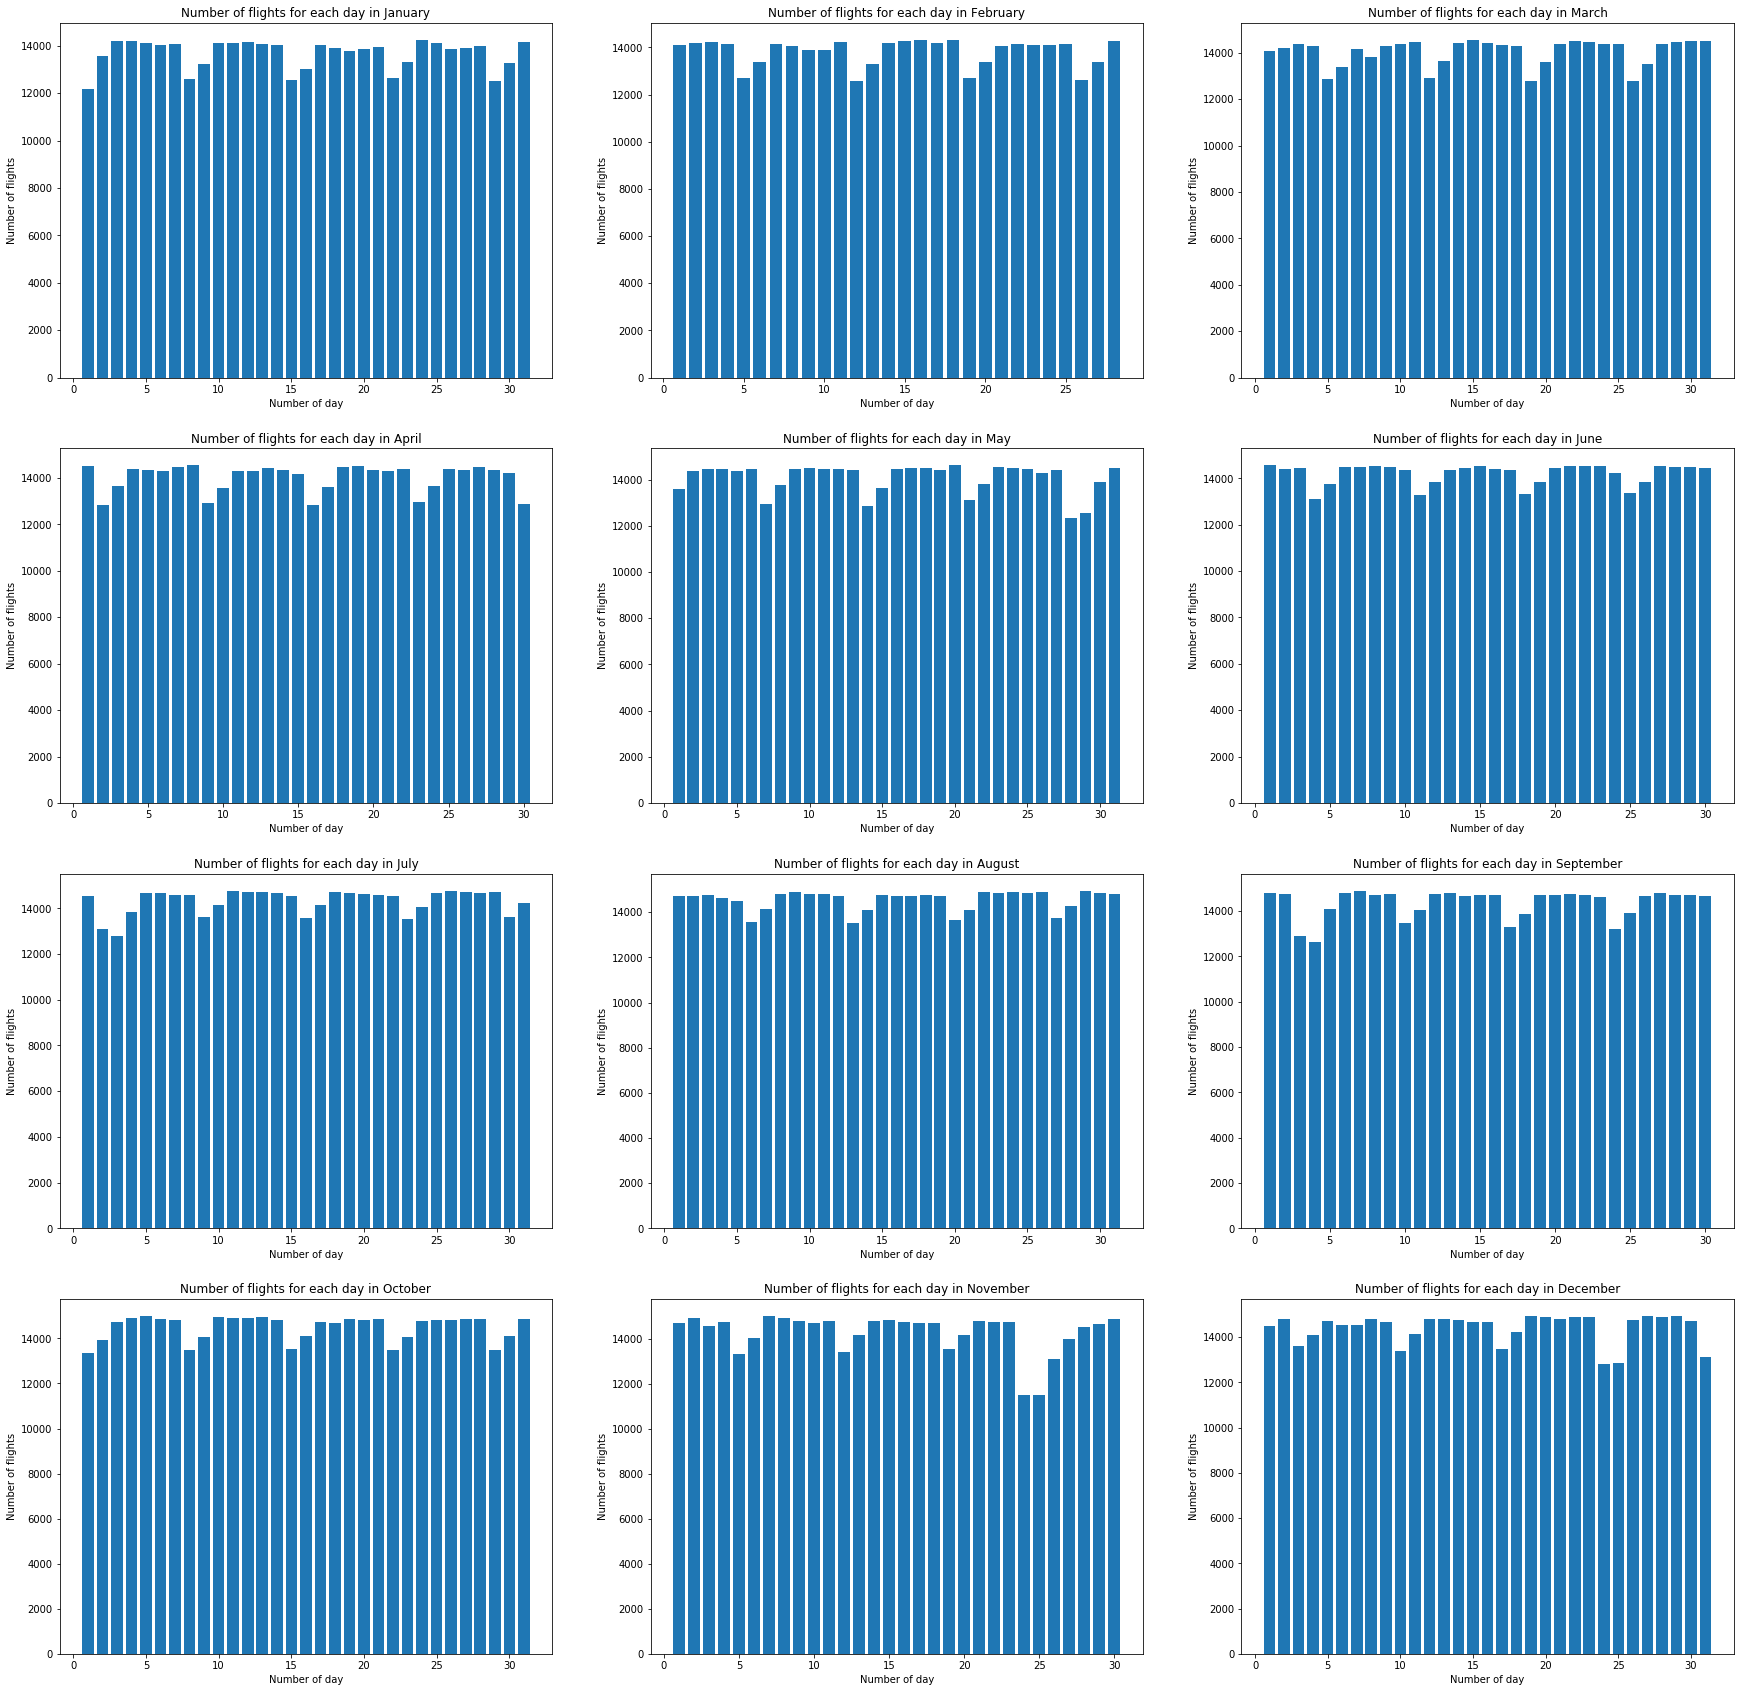

In [15]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

###days of month

#aggregates irrespectively of the month of the year

flights_day_month = df.groupBy('day_of_month').count().orderBy('day_of_month', ascending=1).collect()

pdf_month = pd.DataFrame(data=flights_day_month)


plt.figure(figsize =(12,7))
plt.bar(pdf_month[0], pdf_month[1])
plt.xlabel("Number of day")
plt.ylabel("Number of flights")
plt.title("Number of flights for each day")

#monthly aggregates

count_per_day_monthly = []
for i in range(12):
    count_per_day_monthly.append(df[df.month == i+1].groupBy('day_of_month').count().orderBy('day_of_month', ascending=1).collect())

plt.figure(figsize =(30,30))
for i in range(12):
    days_per_month = [count_per_day_monthly[i][j][1] for j in range(len(count_per_day_monthly[i][:][:]))]
    days = [k + 1 for k in range(len(count_per_day_monthly[i][:][:]))]
    plt.subplot(4,3,i+1)
    plt.title("Number of flights for each day in " +months[i])
    plt.bar(days, days_per_month)
    plt.xlabel("Number of day")
    plt.ylabel("Number of flights")
    
    

**Answer 3.3.1**

For different days of month, on a yearly basis we notice that there is no great difference between the number of the day, except for the 29th 30th and 31st day of each month, because there are less of them globally (only 7 31sts and 11 30ths and 29ths). By looking on a monthly basis however, we notice that there is a pattern. The pattern is "Five bars are higher than the next two". This is what we noticed in the last question, there are more flights during weekdays than during weekends. The first five days of the week than Saturday and Sunday.

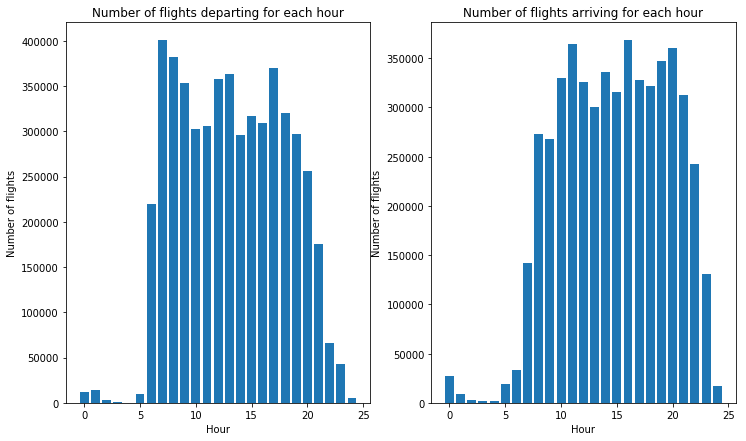

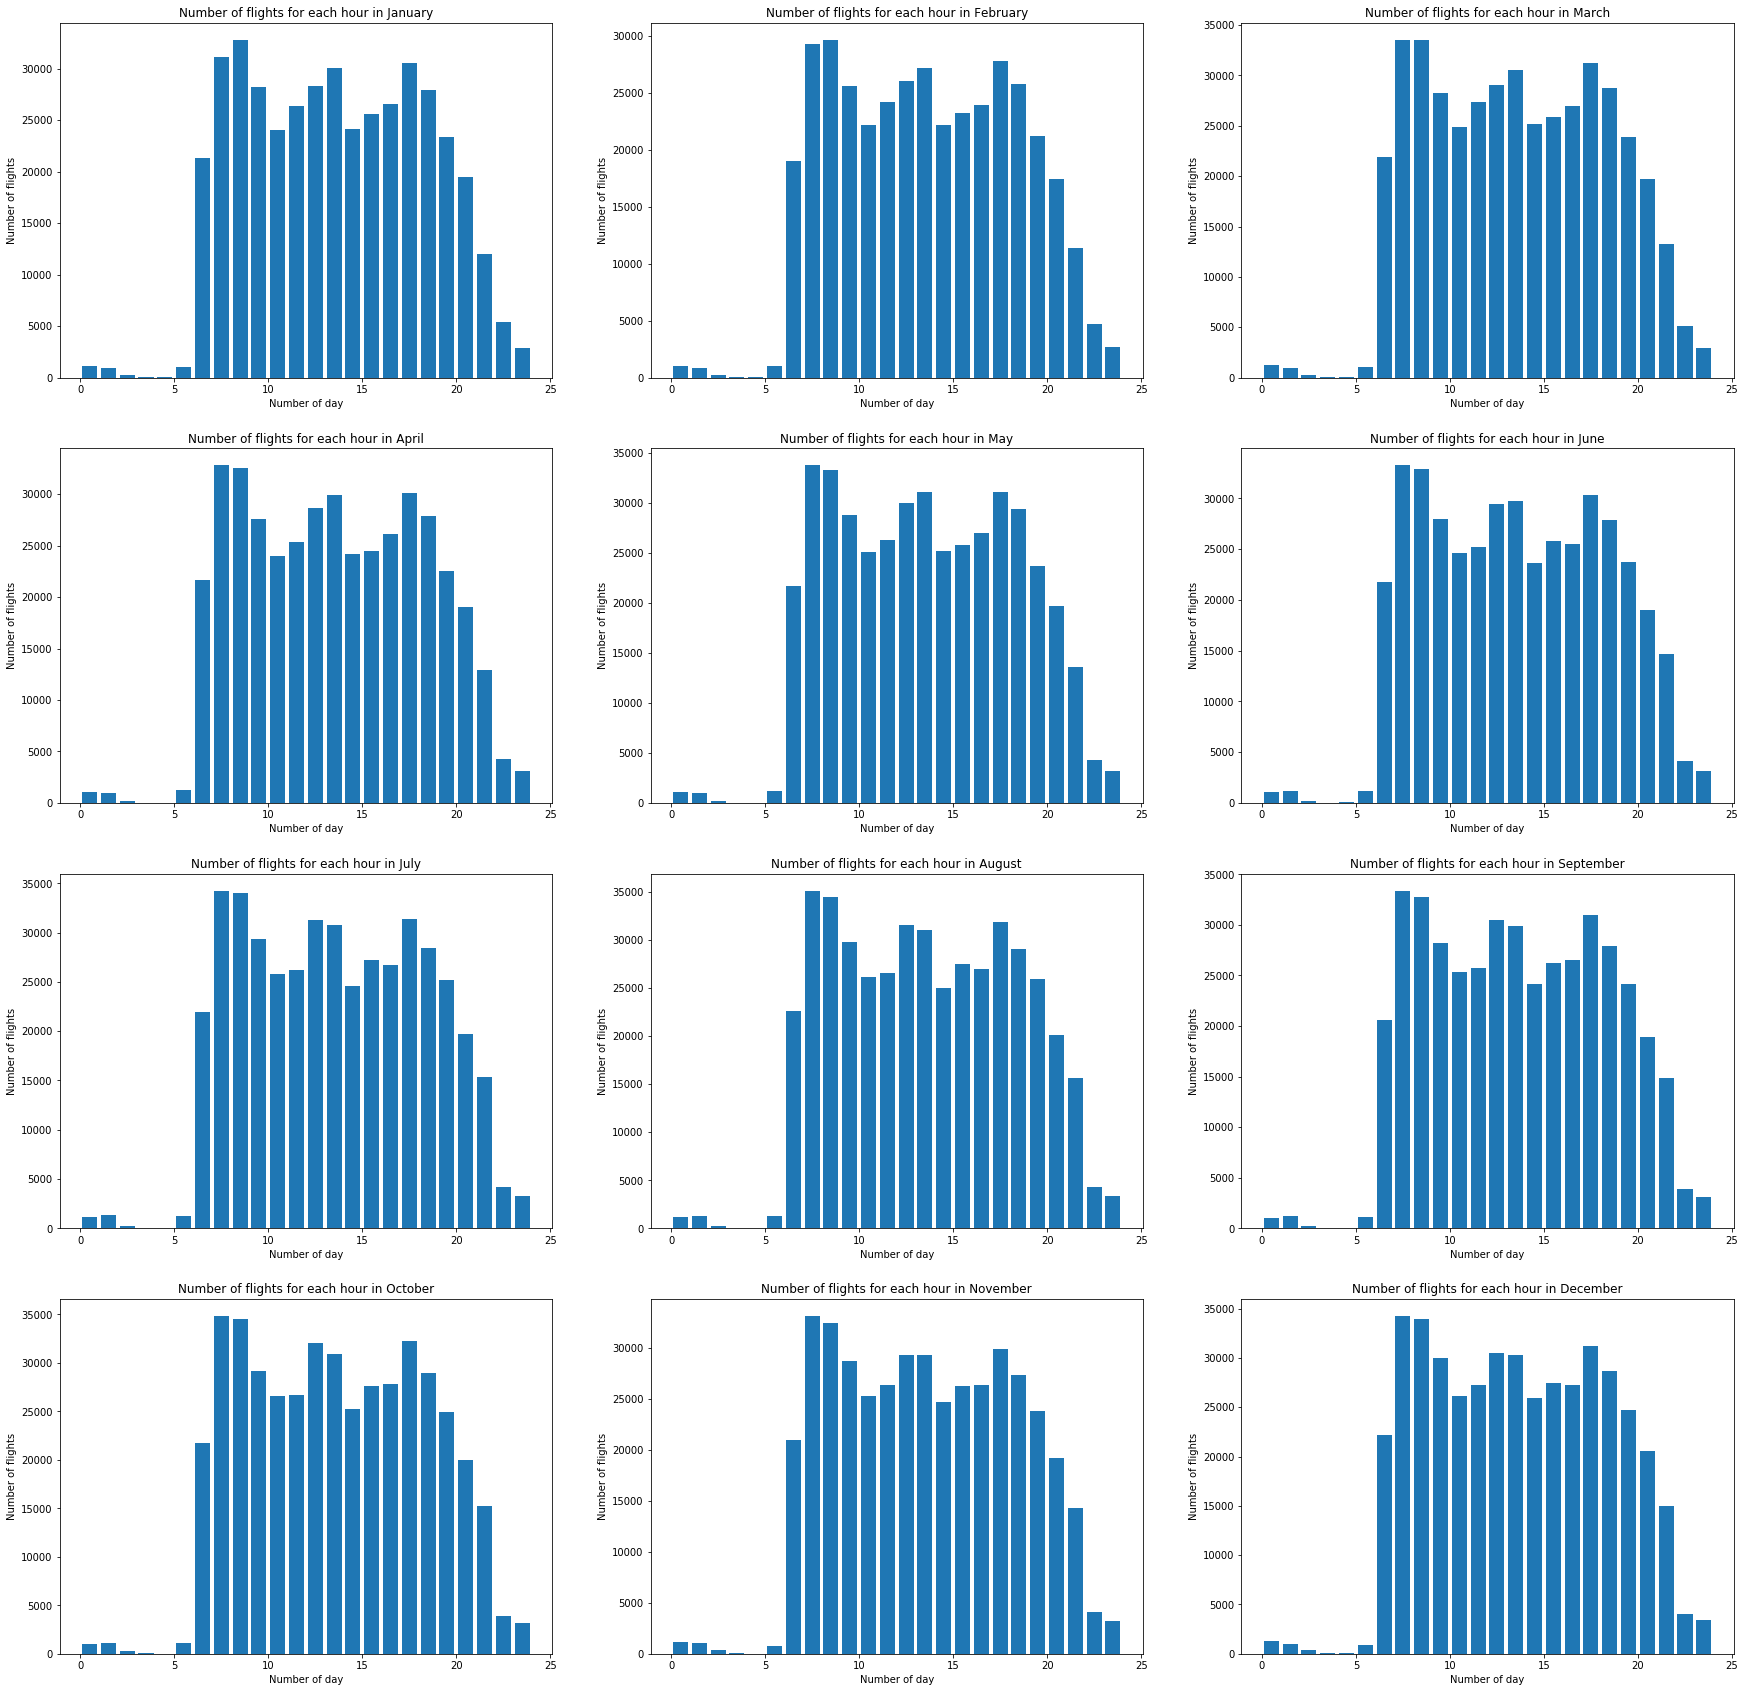

In [16]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
#aggregates irrespectively of the month of the year
#For the hours, there is no feature (hour of the day) we however have scheduled and effective departure and arrival time given in the format HHMM
#we then need to "convert" this into an hour.

df_hour = df.withColumn('departure_hour', round(df.scheduled_departure_time/100, 0)) #adding a column hour to our dataframe
df_hour = df_hour.withColumn('arrival_hour', round(df.scheduled_arrival_time/100, 0)) #adding a column hour to our dataframe

flights_hour_departure = df_hour.groupBy('departure_hour').count().orderBy('departure_hour', ascending=0).collect() #grouping by this new column
pdf_hour_departure = pd.DataFrame(data=flights_hour_departure)

flights_hour_arrival = df_hour.groupBy('arrival_hour').count().orderBy('arrival_hour', ascending=0).collect() #grouping by this new column
pdf_hour_arrival = pd.DataFrame(data=flights_hour_arrival)   


plt.figure(figsize =(12,7))
plt.subplot(1,2,1)
plt.bar(pdf_hour_departure[0], pdf_hour_departure[1])
plt.xlabel("Hour")
plt.ylabel("Number of flights")
plt.title("Number of flights departing for each hour")
plt.subplot(1,2,2)
plt.bar(pdf_hour_arrival[0], pdf_hour_arrival[1])
plt.xlabel("Hour")
plt.ylabel("Number of flights")
plt.title("Number of flights arriving for each hour")


#monthly aggregates

count_hours_monthly = []
for i in range(12):
    each_month = []
    for j in range(24):
        each_month.append(df[df.month == i+1][(df.scheduled_departure_time >= j*100) & (df.scheduled_departure_time < (j + 1)*100)].count())
    count_hours_monthly.append(each_month)

plt.figure(figsize =(30,30))
for i in range(12):
    hours = [k + 0.5 for k in range(24)]
    plt.subplot(4,3,i+1)
    plt.title("Number of flights for each hour in " +months[i])
    plt.bar(hours, count_hours_monthly[i])
    plt.xlabel("Number of day")
    plt.ylabel("Number of flights")
    

**Answer 3.3.2**

The bar charts are pretty similar of the number of flights in the hours of the day according to the month. We can notice that there are very few flights departed between 12PM and 5AM. This is something that we noticed in the first question: less than one percent of the flights depart during this time of the day.

I thought it would be interesting to compare the general departure and arrival time of the flights. We can notice that the pattern is different, but there seems to be a translation of an hour at least. There are a lot less flights arriving between 6AM and 7AM than flights departing at that time. Since the duration of the flights varies (not 1 hours), it explains why there is no translation of the pattern.

### Question 3.4

<div class="alert alert-info">
Which are the **top 20** busiest airports? Compute this in terms of the inbound, outbound and total number of flights.
</div>

In [17]:
inbound = df.groupBy(df.dest_airport).count().orderBy('count', ascending = 0)

outbound = df.groupBy(df.src_airport).count().orderBy('count', ascending = 0)

total = df.withColumn('airport', df.src_airport).union(df.withColumn('airport', df.dest_airport)) #union of the two tables
busiest_airports = total.groupBy('airport').count().orderBy('count', ascending=0)

inbound.show()
outbound.show()
busiest_airports.show()

+------------+------+
|dest_airport| count|
+------------+------+
|         ORD|283720|
|         DFW|260249|
|         ATL|221588|
|         LAX|152959|
|         STL|152800|
|         DEN|144099|
|         PHX|140979|
|         DTW|139435|
|         PIT|131962|
|         CLT|130321|
|         MSP|124758|
|         SFO|117245|
|         EWR|117223|
|         IAH|104409|
|         LGA|101498|
|         BOS| 99331|
|         LAS| 94948|
|         PHL| 93312|
|         DCA| 87670|
|         MCO| 76600|
+------------+------+
only showing top 20 rows

+-----------+------+
|src_airport| count|
+-----------+------+
|        ORD|277741|
|        DFW|256274|
|        ATL|221486|
|        LAX|153494|
|        STL|151609|
|        DEN|141427|
|        PHX|139581|
|        DTW|136837|
|        PIT|130977|
|        CLT|129391|
|        MSP|123222|
|        SFO|118233|
|        EWR|116768|
|        IAH|104182|
|        LGA|101864|
|        BOS|100365|
|        LAS| 94972|
|        PHL| 93585|
|    

**Answer 3.4**

The rankings are the same for the three types (inbound, outbound and total) which seems fair. Some airports have more arrival flights than departure flights and others the opposite.

### Question 3.5
<div class="alert alert-info">
Which are the **top 20** busiest carriers? Compute this in terms of number of flights.
</div>


In [18]:
top_carriers = df.groupBy(df.carrier).count().orderBy('count', ascending = 0)

top_carriers.show()

+-------+------+
|carrier| count|
+-------+------+
|     DL|874526|
|     US|857906|
|     AA|722277|
|     UA|638750|
|     WN|565426|
|     CO|484834|
|     NW|482798|
|     TW|258205|
|     HP|177851|
|     AS|117475|
+-------+------+



**Answer 3.5**

There are only ten distinct carriers in this database so the top20 is only a top10.

## Question 4 
In this series of questions we focus on the computation of statistics about the percentage of delayed flights.

### Question 4.1
<div class="alert alert-info">
What is the percentage of delayed flights for different hours of the day?  

Plot a bar chart and interpret the figure.  


<div class="label label-success">IMPORTANT!</div> A flight is considered as delayed if it's actual arrival time is more than 15 minutes later than the scheduled arrival time.

</div>

Text(0.5,1,'Number of flights delayed for each hour')

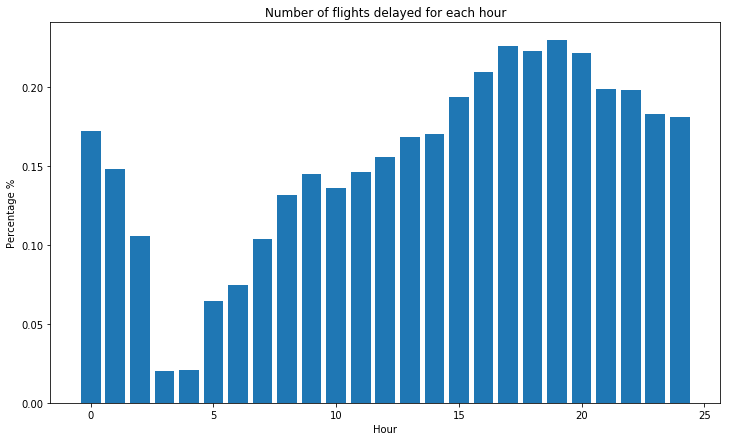

In [19]:
df_delay = df.withColumn('is_delayed', func.when(df['arrival_delay'] >= 15, 1).otherwise(0)) #adding column with a booloean is_delayed

df_delay_hour = df_delay.withColumn('departure_hour', round(df.scheduled_departure_time/100, 0)) #adding a column hour

df_delay_hour = df_delay_hour.groupBy('departure_hour')

df_delay_percentage = df_delay_hour.agg(
    (func.sum('is_delayed')/func.count('*')).alias('delay_percentage')
)#computing and adding a column percentage

df_delay_percentage = df_delay_percentage.orderBy('departure_hour').select(['departure_hour', 'delay_percentage'])

pdf_delay_percentage = pd.DataFrame(data=df_delay_percentage.collect())

plt.figure(figsize =(12,7))
plt.bar(pdf_delay_percentage[0], pdf_delay_percentage[1])
plt.xlabel("Hour")
plt.ylabel("Percentage %")
plt.title("Number of flights delayed for each hour")    

**Answer 4.1**

There are more flights delayed during the day and during the evening but a lot less during the night and early morning. The airports are less busy between midnight and 5AM, which makes delays less likely between 2AM and 8AM because the airports are less busy or have rapidly evacuated the people coming in mass for the first flights at 6 or 7. Then, the delays are accumulated and the airports need to process more and more coming people which makes delays more likely. These accumulated delays explain why the percentage of flights delayed between midnight and 2AM is still high even if the airports are not really busy at that time (there is also probably less staff during night shifts).
It is surprising (or not) to see that more than 20% of the flights can be delayed at one point of the day.

### Question 4.2
<div class="alert alert-info">
You will realize that saying *"at 4 A.M. there is a very low chance of a flight being delayed"* is not giving you a full picture of the situation. Indeed, it might be true that there is very little probability for an early flight to be delayed, but if it does, the delay might be huge, like 6 hours!  

<ul></ul>

Then, the question is: **which hours of the day are characterized by the largest mean delay?** (you can consider the median too)  

Plot a Bar chart and explain it.  

</div>

With data of year 1994, the flight from 3AM to 4AM often depart earlier than in their schedule. The flights in the morning have less delay then in the afternoon and evening.

So, an attentive student should notice here that we have somehow a problem with the definition of delay! Next, we will improve how to represent and visualize data to overcome this problem.

**NOTE**: the following piece of code assumes you correctly answered the previous questions. The naming convention of the DataFrames we use next should be clear enough for you to produce them by answering the questions above.

In [1]:
mean_delay_per_hour = df_delay_hour.agg(
    (func.mean('arrival_delay')).alias('mean_delay')
)
    
mean_delay_per_hour = (
    mean_delay_per_hour
        .orderBy('departure_hour')
        .select(['departure_hour', 'mean_delay'])
    )
    
pdf_mean_delay_per_hour = pd.DataFrame(data=mean_delay_per_hour.collect())

#pdf2 = pd.DataFrame(data=mean_delay_per_hour.collect())
plt.figure(figsize=(12,6))
plt.xlabel("Hours")
plt.ylabel("Ratio of delay")
plt.title('Figure 6: The ratio of delay over hours in day')
plt.grid(True,which="both",ls="-")
bars = plt.bar(pdf_mean_delay_per_hour[0], pdf_mean_delay_per_hour[1], align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if pdf_mean_delay_per_hour[1][i] < 0:
        color = 'lightgreen'
    elif pdf_mean_delay_per_hour[1][i] < 2:
        color = 'green'
    elif pdf_mean_delay_per_hour[1][i] < 4:
        color = 'yellow'
    elif pdf_mean_delay_per_hour[1][i] < 8:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Depart earlier')
patch2 = mpatches.Patch(color='green', label='delay < 2 minutes')
patch3 = mpatches.Patch(color='yellow', label='delay < 4 minutes')
patch4 = mpatches.Patch(color='orange', label='delay < 8 minutes')
patch5 = mpatches.Patch(color='red', label='delay >= 8 minutes')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()

NameError: name 'df_delay_hour' is not defined

**Answer 4.2**

In the new figure (Figure 6), we have more information in a single plot. The flights in 3AM to 4AM have very low probability of being delayed, and actually depart earlier than their schedule. In contrast, the flights in the 4PM to 8PM range have higher chances of being delayed: in more than 50% of the cases, the delay is 8 minutes or more.

This example shows us that the way representing results are also important.


### Question 4.3

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a month. Discuss your findings from the figure.
</div>

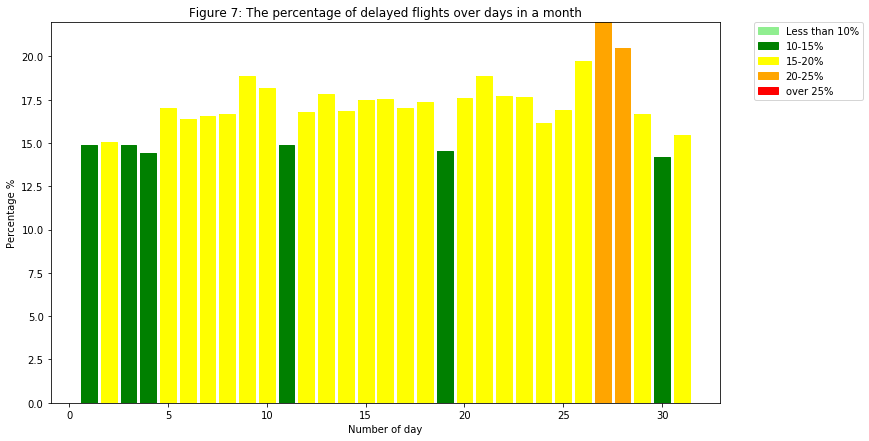

In [21]:
df_day_month = (df_delay.groupBy("day_of_month").agg((100*func.sum('is_delayed')/func.count('*')).alias('delay_percentage'))
        .orderBy("day_of_month")
    )

pdf_day_month = pd.DataFrame(data=df_day_month.collect())

plt.figure(figsize =(12,7))
plt.bar(pdf_day_month[0], pdf_day_month[1])
plt.xlabel("Number of day")
plt.ylabel("Percentage %")
plt.title("Figure 7: The percentage of delayed flights over days in a month")
bars = plt.bar(pdf_day_month[0], pdf_day_month[1], align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if pdf_day_month[1][i] < 10:
        color = 'lightgreen'
    elif pdf_day_month[1][i] < 15:
        color = 'green'
    elif pdf_day_month[1][i] < 20:
        color = 'yellow'
    elif pdf_day_month[1][i] < 25:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Less than 10%')
patch2 = mpatches.Patch(color='green', label='10-15%')
patch3 = mpatches.Patch(color='yellow', label='15-20%')
patch4 = mpatches.Patch(color='orange', label='20-25%')
patch5 = mpatches.Patch(color='red', label='over 25%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()


**Answer 4.3.1**
This distribution is pretty odd, there seems to be a lot more delays on the 27th but an explanation for this fact is pretty complicated, it is probably only a coincidence, there are also some days where the delays are very rare (the 3rd 4th 19th and 30th). We would need data from more years to try to find a correlation between the number of day and the delays.

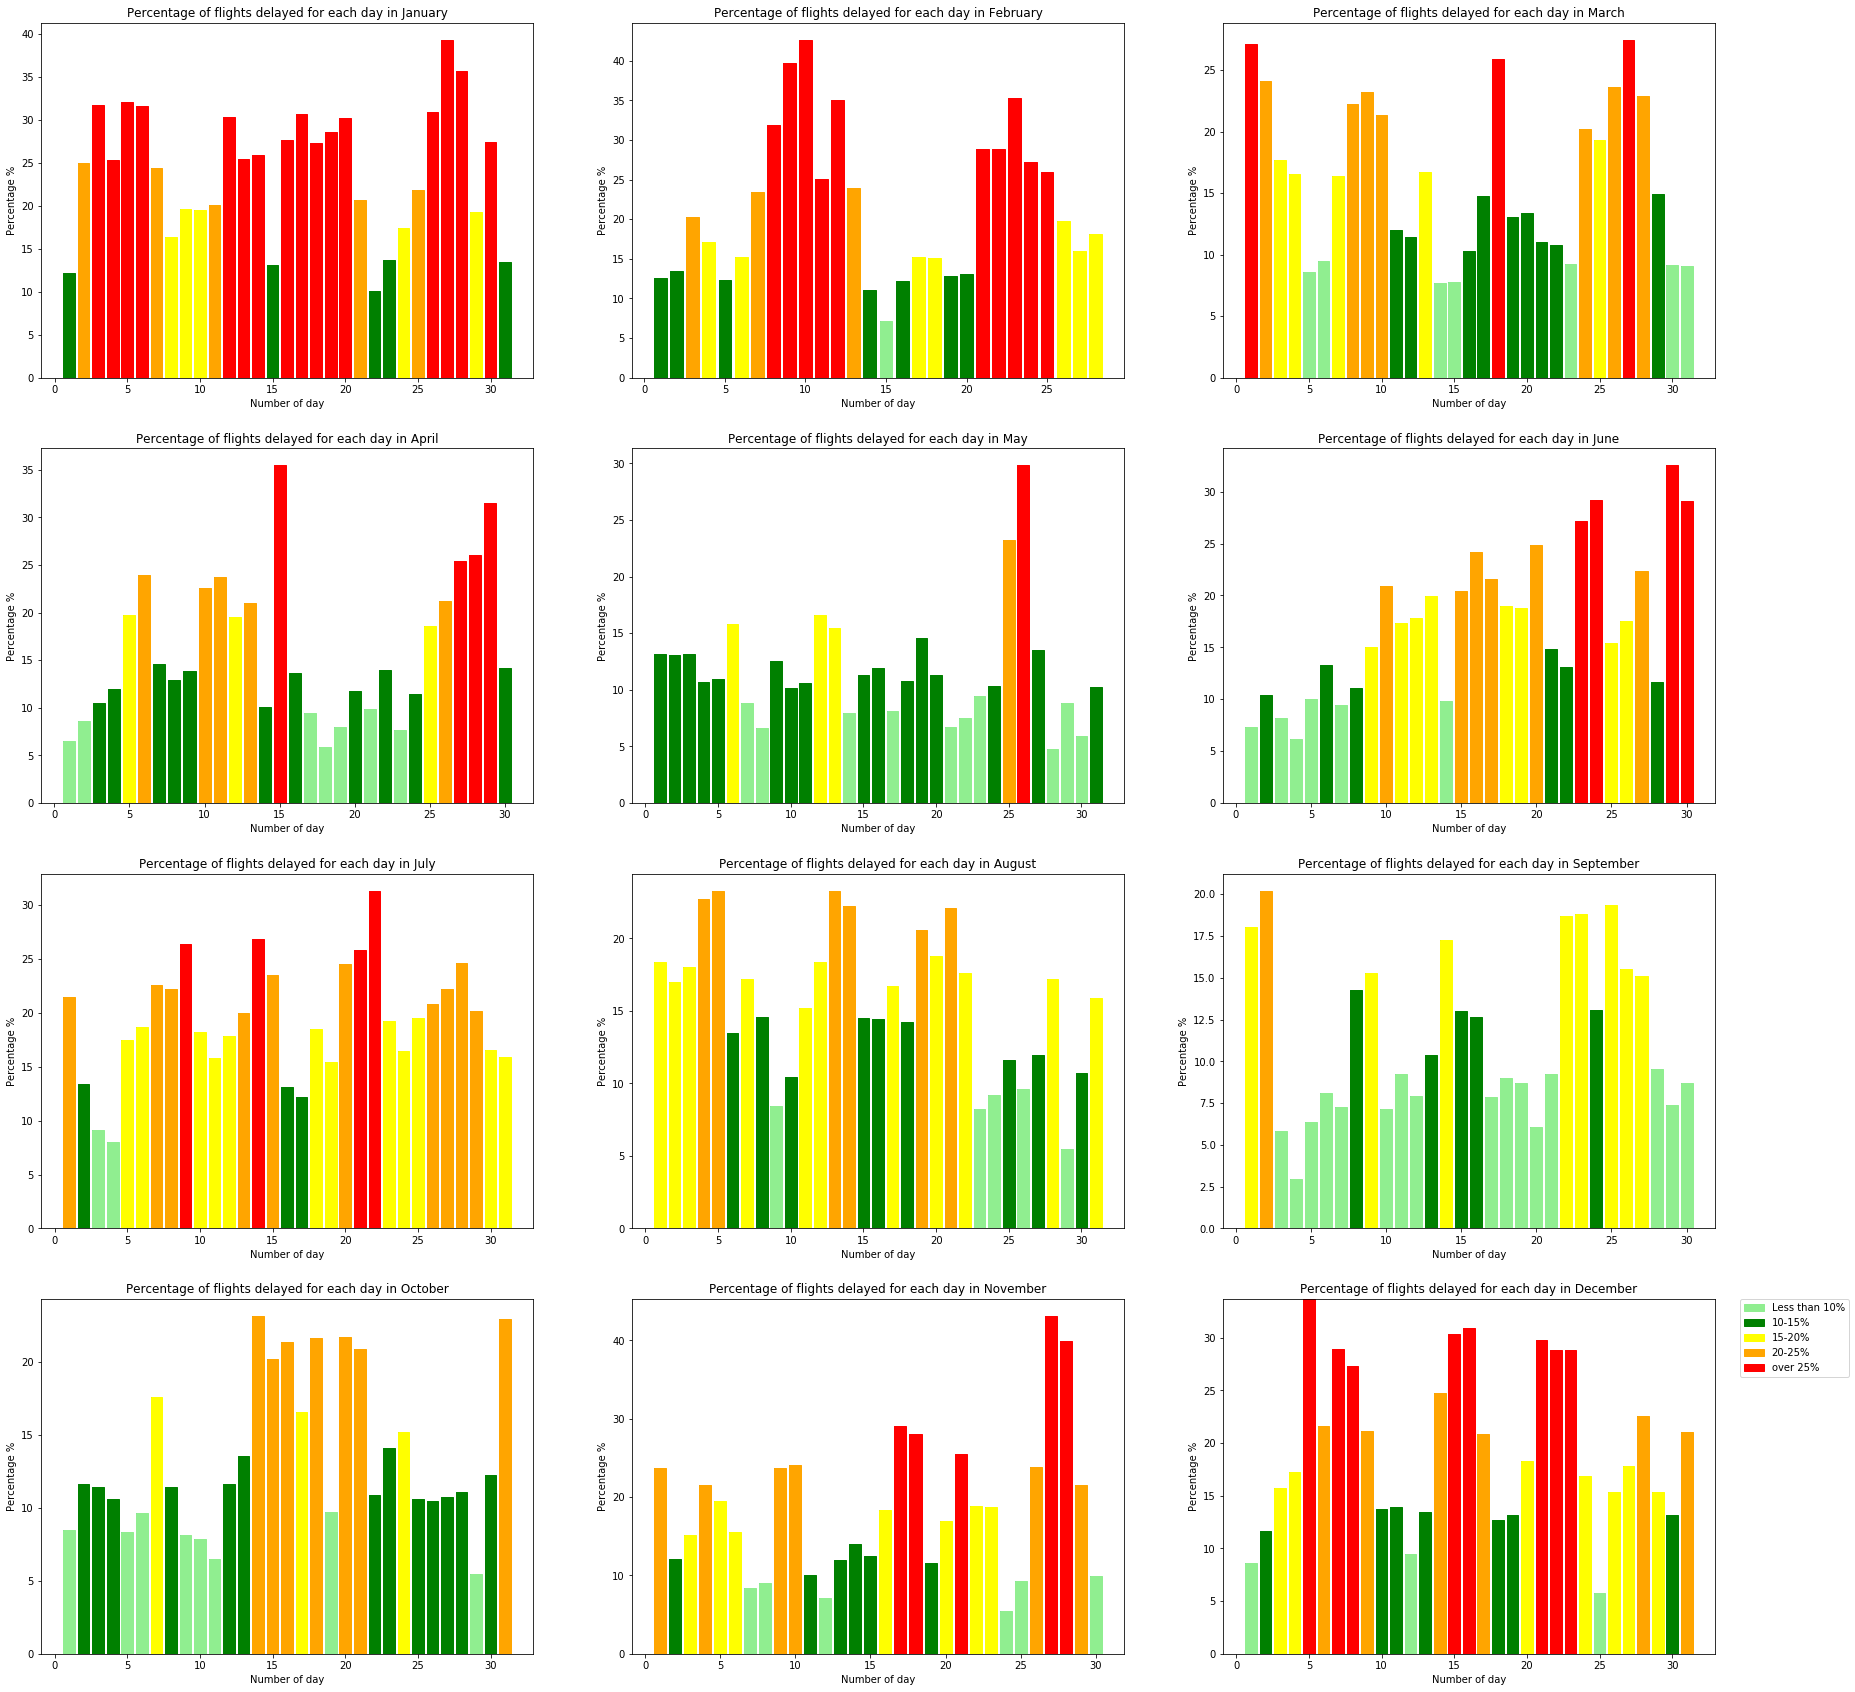

In [22]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

#monthly aggregates
plt.figure(figsize =(30,30))

for i in range(12):
    df_day_month_pm = (df_delay[df_delay.month == i+1].groupBy("day_of_month").agg((100*func.sum('is_delayed')/func.count('*')).alias('delay_percentage'))
                       .orderBy("day_of_month")
    )
    pdf_day_month_pm = pd.DataFrame(data=df_day_month_pm.collect())

    plt.subplot(4,3,i+1)
    plt.bar(pdf_day_month_pm[0], pdf_day_month_pm[1])
    plt.title("Percentage of flights delayed for each day in " +months[i])
    plt.xlabel("Number of day")
    plt.ylabel("Percentage %")
    bars = plt.bar(pdf_day_month_pm[0], pdf_day_month_pm[1], align='center', edgecolor = "black")
    for k in range(0, len(bars)):
        color = 'red'
        if pdf_day_month_pm[1][k] < 10:
            color = 'lightgreen'
        elif pdf_day_month_pm[1][k] < 15:
            color = 'green'
        elif pdf_day_month_pm[1][k] < 20:
            color = 'yellow'
        elif pdf_day_month_pm[1][k] < 25:
            color = 'orange'

        bars[k].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Less than 10%')
patch2 = mpatches.Patch(color='green', label='10-15%')
patch3 = mpatches.Patch(color='yellow', label='15-20%')
patch4 = mpatches.Patch(color='orange', label='20-25%')
patch5 = mpatches.Patch(color='red', label='over 25%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()



**Answer 4.3.2**

I decided to do the monthly aggregates for the percentage of delays of the days of month to try to identify exceptional events. We can easily notice, especially with the colors that January, February and December have a lot more delays than September for example. It is something that we noticed earlier. Moreover we can see that there can be some exceptional days, like the 26th fo May, or the 29th and 30th of June. We would need to find information of what happened on these days to give some explanation. On Christmas Day, there were very few delays however, which seems fair, because people don't travel a lot on Christmas Day.


### Question 4.4

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a week. Discuss your findings from the figure.
</div>

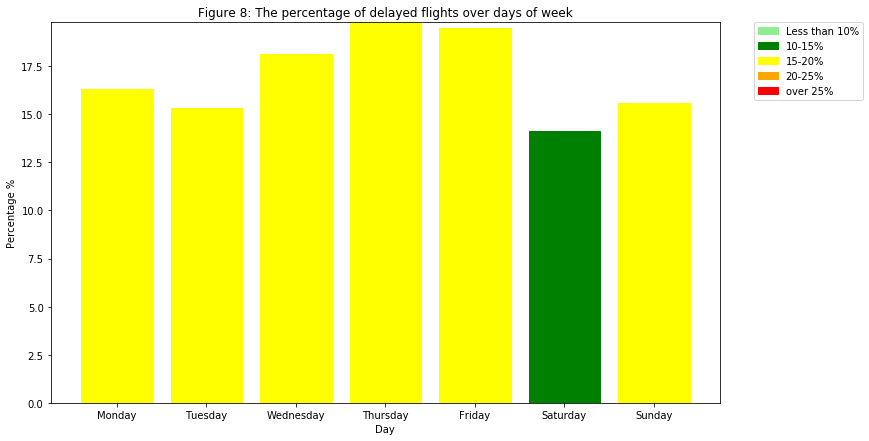

In [23]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_day_week = (df_delay.groupBy("day_of_week").agg((100*func.sum('is_delayed')/func.count('*')).alias('delay_percentage'))
        .orderBy("day_of_week")
    )

pdf_day_week = pd.DataFrame(data=df_day_week.collect())

plt.figure(figsize =(12,7))
plt.bar(pdf_day_week[0], pdf_day_week[1])
plt.xlabel("Day")
plt.xticks(pdf_day_week[0], weekdays)
plt.ylabel("Percentage %")
plt.title("Figure 8: The percentage of delayed flights over days of week")
bars = plt.bar(pdf_day_week[0], pdf_day_week[1], align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if pdf_day_week[1][i] < 10:
        color = 'lightgreen'
    elif pdf_day_week[1][i] < 15:
        color = 'green'
    elif pdf_day_week[1][i] < 20:
        color = 'yellow'
    elif pdf_day_week[1][i] < 25:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Less than 10%')
patch2 = mpatches.Patch(color='green', label='10-15%')
patch3 = mpatches.Patch(color='yellow', label='15-20%')
patch4 = mpatches.Patch(color='orange', label='20-25%')
patch5 = mpatches.Patch(color='red', label='over 25%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()


**Answer 4.4.1**

There seems to be a lot more delays on Wednesdays, Thursdays, and Fridays. Maybe this is due to the fact that people are less tired during the beginning of the week (Mondays and Thursdays) and that the airport is less busy (Saturdays and Sundays). However, these are only assumptions, it could be that there are no correlation between the day of week and delays, a larger dataset would give us more information about this.

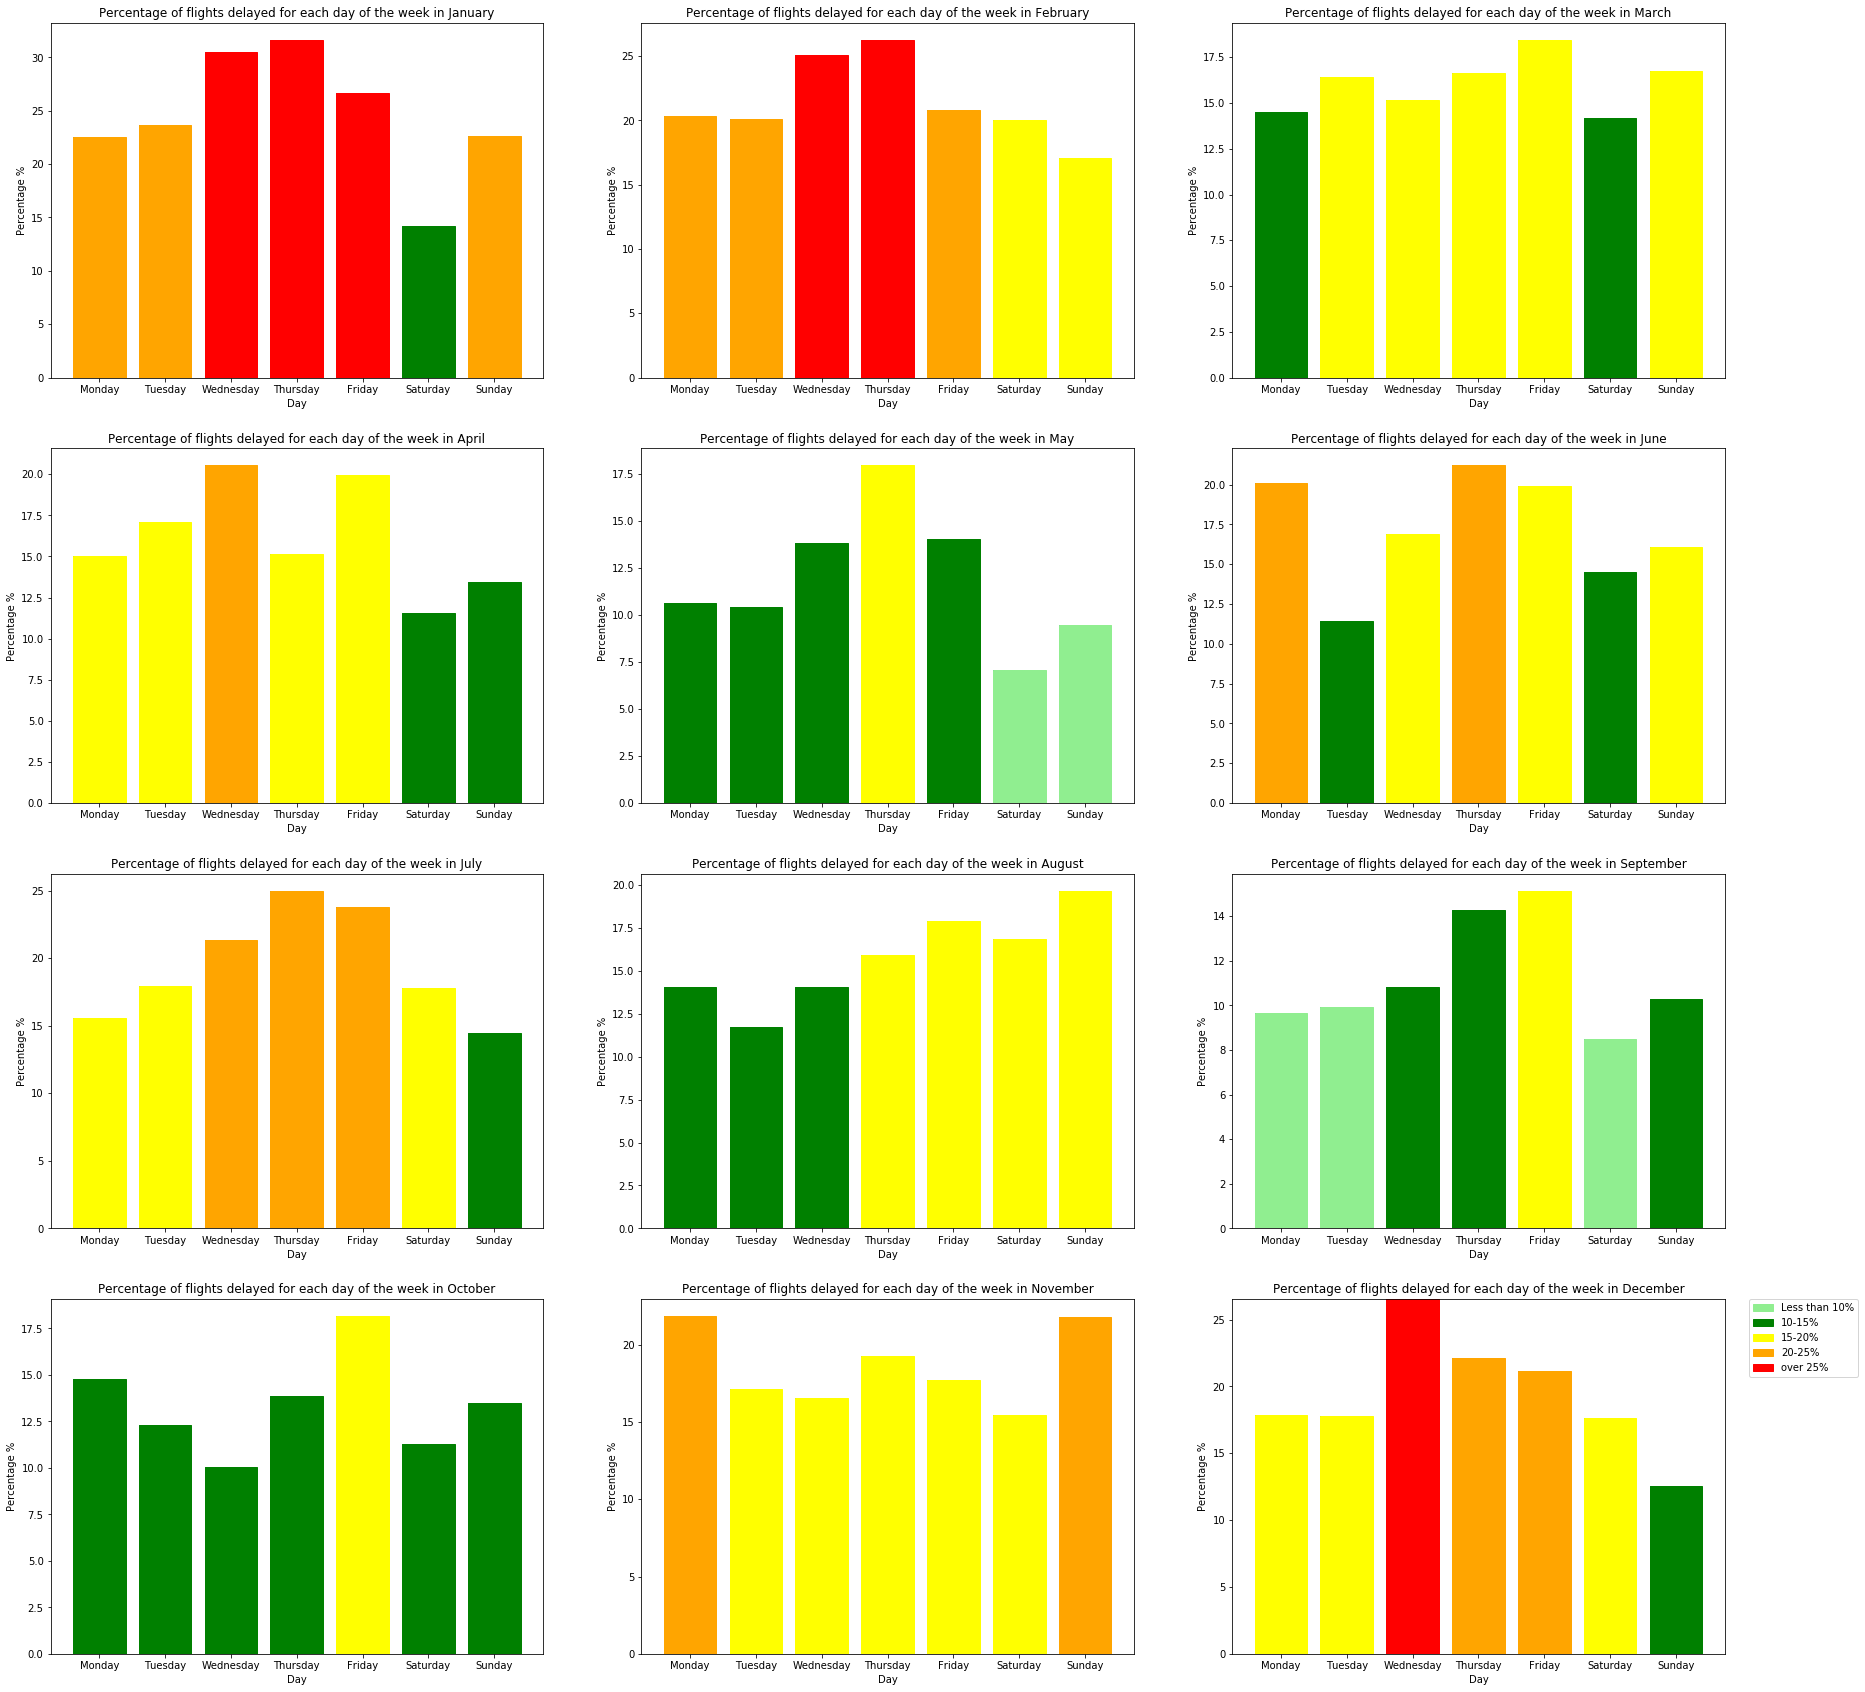

In [24]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

#monthly aggregates

plt.figure(figsize =(30,30))

for i in range(12):
    df_day_week_pm = (df_delay[df_delay.month == i+1].groupBy("day_of_week").agg((100*func.sum('is_delayed')/func.count('*')).alias('delay_percentage'))
                       .orderBy("day_of_week")
    )
    pdf_day_week_pm = pd.DataFrame(data=df_day_week_pm.collect())

    plt.subplot(4,3,i+1)
    plt.bar(pdf_day_week_pm[0], pdf_day_week_pm[1])
    plt.title("Percentage of flights delayed for each day of the week in " +months[i])
    plt.xlabel("Day")
    plt.xticks(pdf_day_week_pm[0], weekdays)
    plt.ylabel("Percentage %")
    bars = plt.bar(pdf_day_week_pm[0], pdf_day_week_pm[1], align='center', edgecolor = "black")
    for k in range(0, len(bars)):
        color = 'red'
        if pdf_day_week_pm[1][k] < 10:
            color = 'lightgreen'
        elif pdf_day_week_pm[1][k] < 15:
            color = 'green'
        elif pdf_day_week_pm[1][k] < 20:
            color = 'yellow'
        elif pdf_day_week_pm[1][k] < 25:
            color = 'orange'

        bars[k].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Less than 10%')
patch2 = mpatches.Patch(color='green', label='10-15%')
patch3 = mpatches.Patch(color='yellow', label='15-20%')
patch4 = mpatches.Patch(color='orange', label='20-25%')
patch5 = mpatches.Patch(color='red', label='over 25%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()



**Answer 4.4.2**

We notice that Saturday and Sundays have very few delays compared to other days. These monthly aggregates do not give us a lot more information than the yearly aggregate. We can notice however that according to the month, the busiest day is not always the same. In October Wednesdays are not really busy even if they are busy most of months.

### Question 4.5
<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over months in a year. Discuss your findings from the figure.
</div>

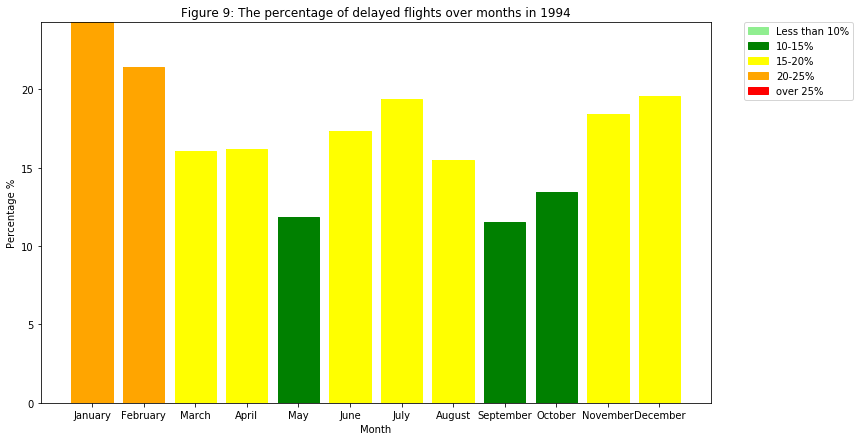

In [25]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

df_month_year = (df_delay.groupBy("month").agg((100*func.sum('is_delayed')/func.count('*')).alias('delay_percentage'))
        .orderBy("month")
    )

pdf_month_year = pd.DataFrame(data=df_month_year.collect())

plt.figure(figsize =(12,7))
plt.bar(pdf_month_year[0], pdf_month_year[1])
plt.xlabel("Month")
plt.xticks(pdf_month_year[0], months)
plt.ylabel("Percentage %")
plt.title("Figure 9: The percentage of delayed flights over months in 1994")
bars = plt.bar(pdf_month_year[0], pdf_month_year[1], align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if pdf_month_year[1][i] < 10:
        color = 'lightgreen'
    elif pdf_month_year[1][i] < 15:
        color = 'green'
    elif pdf_month_year[1][i] < 20:
        color = 'yellow'
    elif pdf_month_year[1][i] < 25:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Less than 10%')
patch2 = mpatches.Patch(color='green', label='10-15%')
patch3 = mpatches.Patch(color='yellow', label='15-20%')
patch4 = mpatches.Patch(color='orange', label='20-25%')
patch5 = mpatches.Patch(color='red', label='over 25%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()


**Answer 4.5**

We could explain the important delays in January and February by using weather conditions. Maybe there was some climattic event during that period in 1994 that provoked this amount of delays. For June, July and August we could argue that these are holiday months and that it is mostly families, and friends going on vacation and less stressed by their flights whihch make the airport processes slower and thus provoking delays. For May, September and October which are months where the weather is nice globally and probably most of the flights are business flights or people travelling alone, the ratio of delays are low.

We are ready now to draw some observations from our data, even if we have only looked at data coming from a year worth of flights:

- The probability for a flight to be delayed is low at the beginning or at the very end of a given months
- Flights on two first weekdays and on the weekend, are less likely to be delayed
- May and September are very good months for travelling, as the probability of delay is low (remember we're working on US data. Do you think this is also true in France?)

Putting things together, we can have a global picture of the whole year!

In [26]:
df_with_delay = df.withColumn('is_delay', func.when(df["arrival_delay"] >= 15, 1).otherwise(0))
statistic_day = df_with_delay.groupBy(['year','month', 'day_of_month', 'day_of_week'])\
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))

# assume that we do statistic on year 1994
statistic_day = statistic_day\
    .orderBy('year', 'month', 'day_of_month', 'day_of_week')
pdf = pd.DataFrame(data=statistic_day.collect())

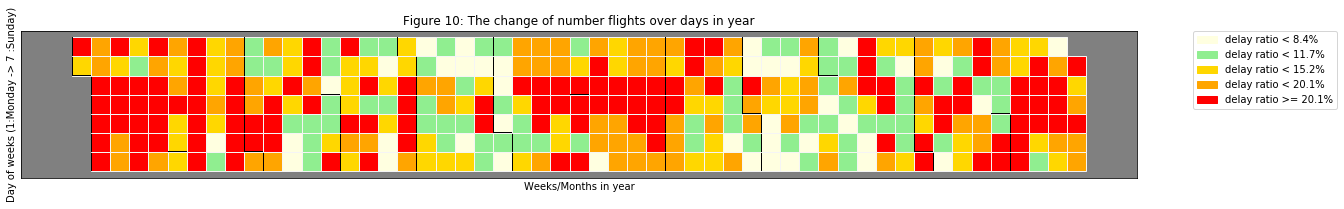

In [27]:
fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)     
plt.xlabel("Weeks/Months in year")
plt.ylabel("Day of weeks (1:Monday -> 7 :Sunday)")
plt.title('Figure 10: The change of number flights over days in year')
  
rec_size = 0.3
from matplotlib.patches import Rectangle
import datetime
num_days = len(pdf[0])
ax.patch.set_facecolor('gray')
ax.set_aspect('equal', 'box')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

for i in range(0, num_days):
    # extract information from the result
    year = pdf[0][i]
    month = pdf[1][i]
    day_of_month = pdf[2][i]
    day_of_week = pdf[3][i]
    day_of_year= datetime.date(year=year, month=month, day=day_of_month).timetuple()
    week_of_year = datetime.date(year=year, month=month, day=day_of_month).isocalendar()[1]
    
    # dealing with the week of the previous year
    if week_of_year == 52 and month == 1:
        week_of_year = 0
        
    # the coordinate of a day in graph
    X = week_of_year*rec_size
    Y = day_of_week*rec_size
    
    # use different colors to show the delay ratio
    color = 'white'
    if pdf[4][i] <= 0.084:
        color = 'lightyellow'
    elif pdf[4][i] <= 0.117:
        color = 'lightgreen'
    elif pdf[4][i] <= 0.152:
        color = 'gold'
    elif pdf[4][i] <= 0.201:
        color = 'orange'
    else:
        color = 'red'
    rect = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, rec_size,
                      alpha=1, facecolor=color, edgecolor='whitesmoke')

    ax.add_patch(rect)
    
    # drawing boders to separate months
    if day_of_month <= 7:
        rect2 = plt.Rectangle((X -rec_size/2.0, Y - rec_size/2.0), 0.01, rec_size,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
    if day_of_month == 1:
        rect2 = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, 0.01,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
ax.autoscale_view()

patch1 = mpatches.Patch(color='lightyellow', label='delay ratio < 8.4%')
patch2 = mpatches.Patch(color='lightgreen', label='delay ratio < 11.7%')
patch3 = mpatches.Patch(color='gold', label='delay ratio < 15.2%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 20.1%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 20.1%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### Question 4.6
<div class="alert alert-info">

What is the delay probability for the top 20 busiest airports?  


By drawing the flight volume of each airport and the associated delay probability in a single plot, we can observe the relationship between airports, number of flights and the delay.  

<div class="label label-success">HINT </div>  Function `<df_colum>.isin(<list>)` helps checking whether a value in column belongs to a list.
<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


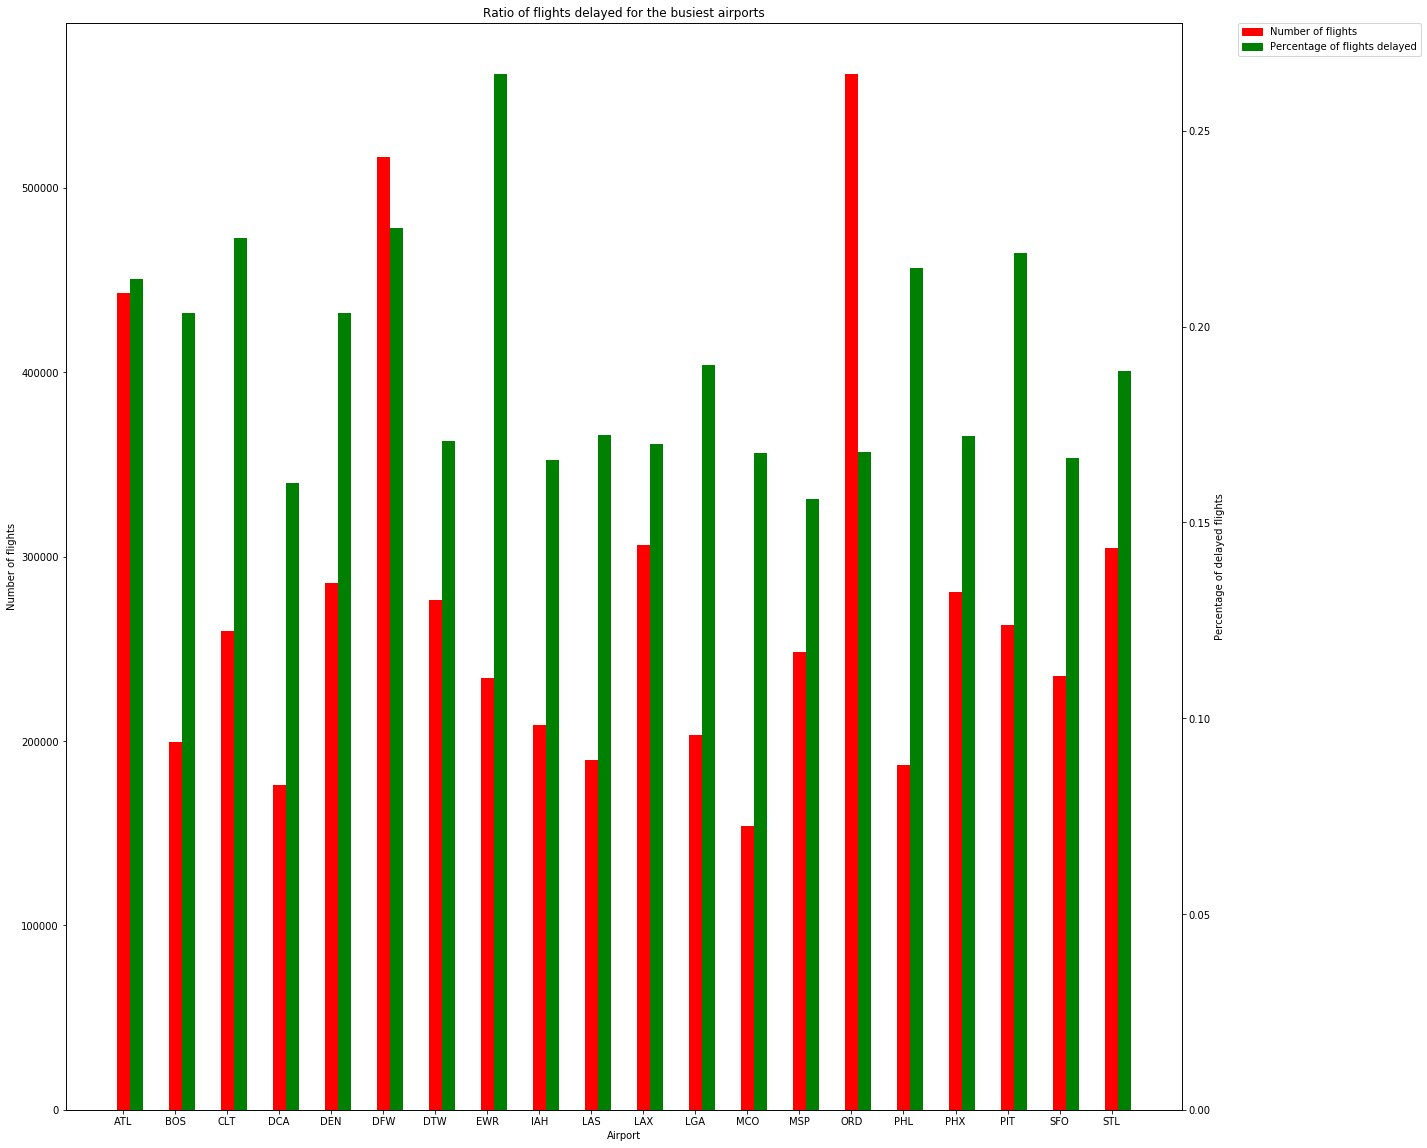

In [28]:
#top20 busiest airports like in 3.4
total = df.withColumn('airport', df.src_airport).union(df.withColumn('airport', df.dest_airport)) #union of the two tables
busiest_airports = total.groupBy('airport').count().orderBy('count', ascending=0)
#we take the top 20
top20 = busiest_airports.take(20)
top20_name = [k[0] for k in top20]
#we do the same as before but filtering on the airport, only taking the 20 firsts
percentage_delay_airport = (df_delay.filter(df_delay.src_airport.isin(top20_name)).groupBy('src_airport')
        .agg((func.sum('is_delayed')/func.count('*')).alias('delay_percentage'))
        .orderBy(['src_airport'])
    )

pdf_delay_airport = pd.DataFrame(data=percentage_delay_airport.collect())
pdf_top20 = pd.DataFrame(data=top20, columns=['src_airport', 'total']).sort_values(by='src_airport')

plt.figure(figsize=(20,20))
plt.title("Ratio of flights delayed for the busiest airports")
ax = plt.subplot(1,1,1)
ax2 = ax.twinx()
ax.set_xlabel("Airport")
ax.set_ylabel("Number of flights")
ax2.set_ylabel("Percentage of delayed flights")
ax.bar([i for i in range(20)], pdf_top20['total'], 0.25, color = 'red')
ax2.bar([i+0.25 for i in range(20)], pdf_delay_airport[1], 0.25, color = 'green')
plt.xticks([i for i in range(20)], pdf_delay_airport[0])
patch1 = mpatches.Patch(color='red', label='Number of flights')
patch2 = mpatches.Patch(color='green', label='Percentage of flights delayed')

plt.legend(handles=[patch1, patch2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

The number of flights in an airport does not really impact the ratio of flights delayed. For example, ORD is the busiest airport but is far from being the airport with the highest percentage of flights delayed. DTW on the opposite is an aiport with relatively low traffic but a very high ratio of flights delayed.

### Question 4.7

<div class="alert alert-info">
What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?  
Comment the figure!

<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


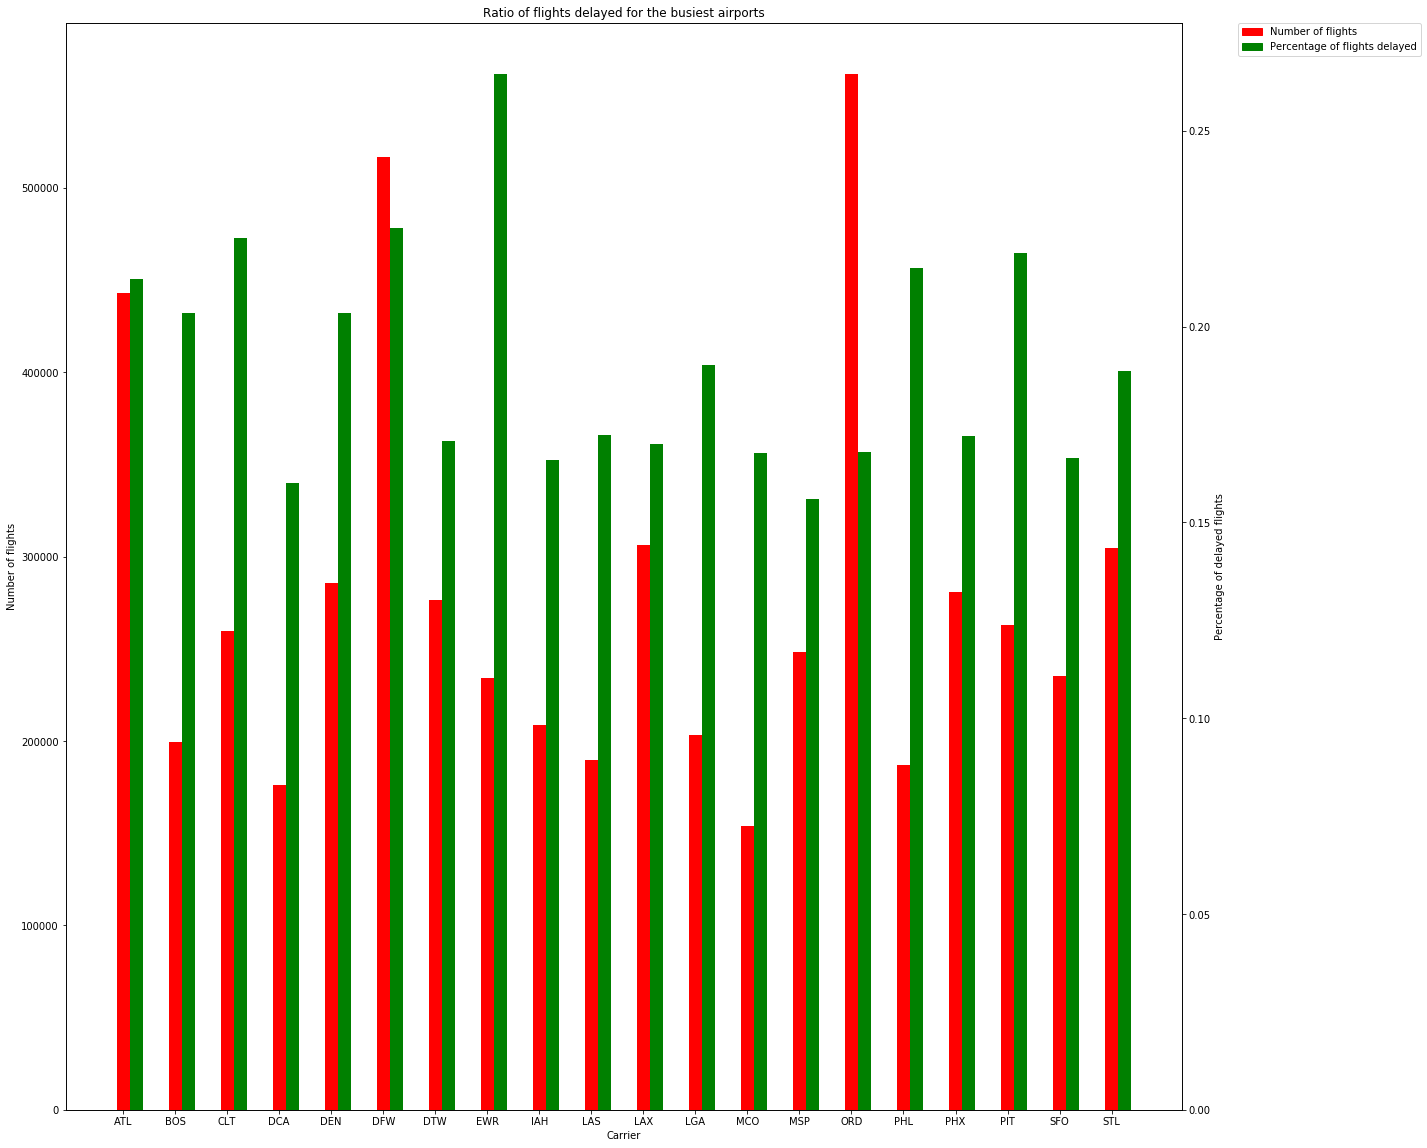

In [29]:
top_carriers = df.groupBy(df.carrier).count().orderBy('count', ascending = 0)

top10 = top_carriers.take(10)
top10_name = [k[0] for k in top10]

#we do the same as before but filtering on the airport, only taking the 20 firsts
percentage_delay_carrier = (df_delay.filter(df_delay.carrier.isin(top10_name)).groupBy('carrier')
        .agg((func.sum('is_delayed')/func.count('*')).alias('delay_percentage'))
        .orderBy(['carrier'])
    )

pdf_delay_carrier = pd.DataFrame(data=percentage_delay_airport.collect())
pdf_top10 = pd.DataFrame(data=top20, columns=['carrier', 'total']).sort_values(by='carrier')

plt.figure(figsize=(20,20))
plt.title("Ratio of flights delayed for the busiest airports")
ax = plt.subplot(1,1,1)
ax2 = ax.twinx()
ax.set_xlabel("Carrier")
ax.set_ylabel("Number of flights")
ax2.set_ylabel("Percentage of delayed flights")
ax.bar([i for i in range(20)], pdf_top10['total'], 0.25, color = 'red')
ax2.bar([i+0.25 for i in range(20)], pdf_delay_carrier[1], 0.25, color = 'green')
plt.xticks([i for i in range(20)], pdf_delay_carrier[0])

patch1 = mpatches.Patch(color='red', label='Number of flights')
patch2 = mpatches.Patch(color='green', label='Percentage of flights delayed')

plt.legend(handles=[patch1, patch2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Same as for the airports, the number of flights of a carrier does not seem to impact the percentage of flights delayed.

## Addition (bonus) questions

### Additional data
In the HDFS file system you have used for running the Notebook, you will notice that there are several other years available (in addition to 1994).

There are some other datasets that related to this use case:

- Airport IATA Codes to City names and Coordinates mapping: http://stat-computing.org/dataexpo/2009/airports.csv
- Carrier codes to Full name mapping: http://stat-computing.org/dataexpo/2009/carriers.csv
- Information about individual planes: http://stat-computing.org/dataexpo/2009/plane-data.csv
- Weather information: http://www.wunderground.com/weather/api/. You can subscribe for free to the developers' API and obtain (at a limited rate) historical weather information in many different formats. Also, to get an idea of the kind of information is available, you can use this link: http://www.wunderground.com/history/

### Question 5.1

<div class="alert alert-info">

Which airports are present in the dataset only as destination airport?

Which airport is present only as source airport in the dataset? 

</div>

### Question 5.2

<div class="alert alert-info">

Which airports have biggest delay probability ?

Which cities have largest delay duration in average ?

</div>

### Question 5.3

<div class="alert alert-info">

Is there any relationship between weather condition and the delay of flights in 1994 ?

</div>
